# Comparing Tautomer Generation Algorithms

[Tautomers](https://en.wikipedia.org/wiki/Tautomer) are chemical structures that can interconvert under given conditions. For example, an amino acid has a neutral form, and a zwitterionic form with separated positive and negative charges. Cheminformatics packages have algorithms to generate tautomers based on rules. This post compares their results to each other and to experimentally-observed tautomers.

![Tautomeric forms of an amino acid: neutral (1) and zwitterionic (2)](../images/Amino_acid_zwitterions.svg)

[Image](https://commons.wikimedia.org/wiki/File:Amino_acid_zwitterions.svg) credit: [TimVickers](https://en.wikipedia.org/wiki/User:TimVickers) vector version by [YassineMrabet](https://commons.wikimedia.org/wiki/User:YassineMrabet)


The tautomer generation algorithms discussed below are based on rules from Markus Sitzmann, Wolf-Dietrich Ihlenfeldt, and Marc C. Nicklaus, “Tautomerism in Large Databases”, _JCAMD_ 24:521 (2010) https://doi.org/10.1007/s10822-010-9346-4.

RDKit has two tautomer generation algorithms, [GetV1TautomerEnumerator](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html#rdkit.Chem.MolStandardize.rdMolStandardize.GetV1TautomerEnumerator) and the [new algorithm, TautomerEnumerator](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html#rdkit.Chem.MolStandardize.rdMolStandardize.TautomerEnumerator). The [2022.03 release notes](https://www.rdkit.org/docs/BackwardsIncompatibleChanges.html#tautomer-enumeration-improvements) state:
> The rules for tautomer enumeration in MolStandardize have been updated to more closely match the rules in the original publication. These changes primarily consist of making the rules more specific; the consequence is that less tautomers will be generated with this version.

but maintainer Greg Landrum [wrote](https://github.com/rdkit/rdkit/discussions/6997#discussioncomment-7893160)
> That's [the new TautomerEnumerator returning fewer examples than the previous rules V1] not something I've noticed. The code change adds a missed case to the enumeration rule set, so at first glance you'd expect it to always produce more tautomers, but I suppose that could still result in a smaller number of tautomers in the end because of how the transformations interact with each other.

So one purpose of this blog post is to empirically answer the question of whether the new RDKit algorithm produces more or fewer tautomers than the V1 algorithm.

NIH [CADD Group Chemoinformatics Tools and User Services (CACTUS)](https://cactus.nci.nih.gov/) also has algorithms that can be run on a [Tautomerizer web page](https://cactus.nci.nih.gov/cgi-bin/tautomerize.tcl) or with the package [CACTVS](https://www.cactvs.com/academic/) from Xemistry GmbH. Marc Niclaus notes that CACTVS has "many additional transforms vs. the ones we used in 2010 [for the paper cited above]. This now includes numerous ring-chain and valence tautomerism rules, for a total of 119 rules" (private communication). We compare these two NIH algorithms to the new RDKit algorithm. Because I couldn't install CACTVS on my computer due to CPU compatibility, I used the web site which has 86 rules, and Marc kindly ran CACTVS on his computer for a few structures using "exhaustive multi-step enumeration iteratively with all rules, until no more new tautomer is found (with a limit of 1,000 attempts)".

To empirically compare these algorithms, we need a set of molecules which have tautomers: Many molecules will not have any tautomers. Nicklaus and team also created [Tautomer Structures Extracted from Experimental Literature](https://cactus.nci.nih.gov/download/tautomer/), with 
> 5,977 structures extracted from experimental literature representing 2,819 cases of tautomeric tuples (mostly tautomer pairs but also a few triples and higher-order tuples). Note that the number of structurally different tuples is only 1,776 (comprising 3,884 different structures) since some tuples are differentiated from each other only by experimental conditions such as solvent, spectroscopy method, etc.

We use release 3 in Excel format, specifically [Tautomer_database_release_3a.xlsx](https://cactus.nci.nih.gov/download/tautomer/Tautomer_database_release_3a.xlsx).

## Code foundation

In [11]:
import sys
print(sys.version)

3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)]


In [12]:
# !pip install rdkit polars>=0.20.7 seaborn matplotlib xlsx2csv

In [13]:
from typing import Iterable, Callable
from collections import Counter
import statistics
from statistics import StatisticsError

In [14]:
from rdkit.Chem import AllChem as Chem
from rdkit import RDLogger
from rdkit.Chem import Draw, rdFMCS
from rdkit.Chem import Mol
from rdkit.Chem.MolStandardize import rdMolStandardize
import polars as pl
import polars.selectors as cs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [15]:
# Suppress RDKit warnings so it doesn't warn about SMILES that produce molecules which violate a rule,
# which would produce many warnings as we create thousands of molecules
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [16]:
def mol_from_sml(sml: str) -> Mol:
    """Create an RDKit molecule from a SMILES string.
    RDKit cannot create molecules from some SMILES strings if it tries to sanitize them,
    but can if it does not sanitize them.
    It is preferable to sanitize molecules if possible because that does things such as
    delocalize aromatic bonds (instead of alternating single and double bonds),
    which makes different structures (single-double vs. double-single bond sequence) give the same molecule.

    :param sml: SMILES string
    """
    # Try sanitizing molecule first
    mol = Chem.MolFromSmiles(sml, sanitize=True)
    if mol is not None:
        return mol
    # If sanitization fails, turn it off and try creating molecule again
    mol = Chem.MolFromSmiles(sml, sanitize=False)
    return mol

In [17]:
def canon_sml_or_none(mol):
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

In [18]:
def canonicalize(sml):
    # Try converting input SMILES into mol
    # Try sanitizing molecule first
    mol = Chem.MolFromSmiles(sml, sanitize=True)
    if mol is None:
        # If sanitization fails, turn it off and try creating molecule again
        mol = Chem.MolFromSmiles(sml, sanitize=False)

    # 
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

## Preparing the data from the tautomer database

In [19]:
# Tautomer database from https://cactus.nci.nih.gov/download/tautomer/
file_name = "../data/Tautomer_database_release_3a.xlsx"

# If you want to use only the first row for quicker debugging, use this file instead
# file_name = "../data/Tautomer_database_release_3a_first.xlsx"

# The name of the sheet to process
sheet_name = "Tautomer_database"

We start by reading the data from the sheet in the Excel file of the tautomer database using [`polars.read_excel`](https://docs.pola.rs/py-polars/html/reference/api/polars.read_excel.html).

In [20]:
df = pl.read_excel(
    source=file_name, 
    sheet_name=sheet_name,
    read_csv_options={"infer_schema_length":10000},
    )
df.head()

/var/folders/9w/cn8tqbv976gckxd0c9cbr1sw0000gn/T/ipykernel_62204/3709418447.py:1: DeprecationWarning: `the argument read_csv_options` for `read_excel` is deprecated. It has been renamed to `read_options`.
  df = pl.read_excel(


Ref,Size,Solvent,Solvent_Proportion,Solvent_Mixture,Temperature,pH,Experimental_Method,Entry_ID1,Type_1,ID_Hash_1,FICTS_1,HASHISY_1,FICuS_1,TAUTOHASH_1,uuuuu_1,Std_InChIKey_1,Std_InChI_1,SMILES_1,Mol_Formula_1,Mol_Weight_1,IUPAC_Name_1,Quantitative_ratio_1,Qualitative_prevalence_1,Prevalence_Category_1,Filename_1,Publication_DOI_1,Publication_ID_1,Authors_1,Affiliation_1,Title_1,Section_1,Page_Number(s)_1,Notes_1,Cmpd_Number_1,Entry_ID2,Type_2,…,Publication_DOI_4,Publication_ID_4,Authors_4,Affiliation_4,Title_4,Section_4,Page_Number(s)_4,Notes_4,Cmpd_Number_4,Entry_ID5,Type_5,Transf_1_5,ID_Hash_5,FICTS_5,HASHISY_5,FICuS_5,TAUTOHASH_5,uuuuu_5,Std_InChIKey_5,Std_InChI_5,SMILES_5,Mol_Formula_5,Mol_Weight_5,IUPAC_Name_5,Quantitative_ratio_5,Qualitative_Prevalence_5,Prevalence_Category_5,Filename_5,Publication_DOI_5,Publication_ID_5,Authors_5,Affiliation_5,Title_5,Section_5,Page_Number(s)_5,Notes_5,Cmpd_Number_5
i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,i64,str,str,str,str,str,str,str,i64,str,str
1,2,"""Gas phase""","""nul""","""no""","""377.15-417.15""","""nul""","""1H NMR spectra…","""Prog. NMR. Spe…","""Diketo""","""8da8a44a54e4cd…","""748BBAA5E5F382…","""748BBAA5E5F382…","""748BBAA5E5F382…","""748BBAA5E5F382…","""748BBAA5E5F382…","""InChIKey=YRKCR…","""InChI=1S/C5H8O…","""O=C(C)CC(C)=O""","""C5H8O2""",100.117,"""pentane-2,4-di…","""nul""","""Observed""",1,"""(1)_Claramunt_…","""10.1016/j.pnmr…","""Prog. NMR. Spe…","""Claramunt, R. …","""Departamento d…","""The use of NMR…","""Scheme 1""","""171""","""nul""","""1c""","""Prog. NMR. Spe…","""Keto-enol""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,2,"""Gas phase""","""nul""","""no""","""nul""","""nul""","""nul""","""Prog. NMR. Spe…","""NH""","""ef8866bd4d9949…","""AF721AB4BAA47F…","""AF721AB4BAA47F…","""AF721AB4BAA47F…","""AF721AB4BAA47F…","""E0755E1A90D93F…","""InChIKey=QWENR…","""InChI=1S/C2H3N…","""N1=CC=N[NH]1""","""C2H3N3""",69.0658,"""2H-triazole""","""nul""","""Only observed""",4,"""(1)_Claramunt_…","""10.1016/j.pnmr…","""Prog. NMR. Spe…","""Claramunt, R. …","""Departamento d…","""The use of NMR…","""Scheme 3""","""172""","""nul""","""8b""","""Prog. NMR. Spe…","""NH""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,2,"""HMPT""","""nul""","""no""","""nul""","""nul""","""13C NMR spectr…","""Prog. NMR. Spe…","""NH""","""7714934ea0f29d…","""96D7C0A293F7BC…","""96D7C0A293F7BC…","""B5EA71BA1BFB8B…","""B5EA71BA1BFB8B…","""B5EA71BA1BFB8B…","""InChIKey=XKVUY…","""InChI=1S/C4H6N…","""CC1=CC=NN1""","""C4H6N2""",82.1048,"""5-methyl-1H-py…","""nul""","""Predominant""",3,"""(1)_Claramunt_…","""10.1016/j.pnmr…","""Prog. NMR. Spe…","""Claramunt, R. …","""Departamento d…","""The use of NMR…","""Scheme 3""","""172""","""nul""","""7b""","""Prog. NMR. Spe…","""NH""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,2,"""DMSO-d6""","""nul""","""no""","""nul""","""nul""","""1H NMR spectra…","""Prog. NMR. Spe…","""NH""","""8c6a7d710c6321…","""DD375DCBC6DDA9…","""DD375DCBC6DDA9…","""DD375DCBC6DDA9…","""DD375DCBC6DDA9…","""DD375DCBC6DDA9…","""InChIKey=OWLHY…","""InChI=1S/C7H6N…","""N=N=NC1=NNC2=C…","""C7H6N5""",160.1579,"""3-[(imino-lamb…","""nul""","""Predominant""",3,"""(1)_Claramunt_…","""10.1016/j.pnmr…","""Prog. NMR. Spe…","""Claramunt, R. …","""Departamento d…","""The use of NMR…","""Scheme 4""","""173""","""nul""","""9a""","""Prog. NMR. Spe…","""NH""",…,null,null,nu

In case there are any empty rows, let's filter down to rows where Ref is not null:

In [21]:
df = df.filter(pl.col("Ref").is_not_null())

And we get the 2,819 cases cited in the data documentation.

In [22]:
df.shape

(2819, 147)

The number of unique Ref values is 1776, as stated in the data documentation:

In [23]:
Ref_count = df['Ref'].n_unique()
Ref_count

1776

Let's cut down the number of columns to remove those relating to experimental conditions, etc. by keeping only `Ref` and the SMILES and Std_InChI columns. We can use a combination of selectors within `df.select`():
- To keep the column "Ref", we simply use `"Ref"`
- To keep the columns starting with "SMILES_" or "Std_InChI_", we use `cs.starts_with("SMILES_", "Std_InChI_")`

By putting those two selectors in the same `df.select()`, we select columns matching either criterion.

In [24]:
df = df.select("Ref", cs.starts_with("SMILES_", "Std_InChI_"))
df.head()

Ref,Std_InChI_1,SMILES_1,Std_InChI_2,SMILES_2,Std_InChI_3,SMILES_3,Std_InChI_4,SMILES_4,Std_InChI_5,SMILES_5
i64,str,str,str,str,str,str,str,str,str,str
1,"""InChI=1S/C5H8O…","""O=C(C)CC(C)=O""","""InChI=1S/C5H8O…","""O/C(C)=C\C(C)=…",null,null,null,null,null,null
2,"""InChI=1S/C2H3N…","""N1=CC=N[NH]1""","""InChI=1S/C2H3N…","""[NH]1N=NC=C1""",null,null,null,null,null,null
3,"""InChI=1S/C4H6N…","""CC1=CC=NN1""","""InChI=1S/C4H6N…","""CC1=NNC=C1""",null,null,null,null,null,null
4,"""InChI=1S/C7H6N…","""N=N=NC1=NNC2=C…","""InChI=1S/C7H6N…","""N=N=NC1=C2C=CC…",null,null,null,null,null,null
5,"""InChI=1S/C11H1…","""CC1([C@H]2C(C=…","""InChI=1S/C11H1…","""CC1([C@H](CC[C…","""InChI=1S/C11H1…","""CC1([C@H](CC[C…",null,null,null,null


As an aside, if we instead used chained select clauses, `df.select("Ref").select(cs.starts_with("SMILES_", "Std_InChI_"))`, we would select no columns because the first clause selects only "Ref", and then within that one-column dataframe the second clause selects only those starting with  "SMILES_" or "Std_InChI_".

In [25]:
df_no_cols = df.select("Ref").select(cs.starts_with("SMILES_", "Std_InChI_"))
df_no_cols

shape: (0, 0)
┌┐
╞╡
└┘

Let's review the columns left in our dataframe:

In [26]:
df.columns

['Ref',
 'Std_InChI_1',
 'SMILES_1',
 'Std_InChI_2',
 'SMILES_2',
 'Std_InChI_3',
 'SMILES_3',
 'Std_InChI_4',
 'SMILES_4',
 'Std_InChI_5',
 'SMILES_5']

The Excel sheet has sets of columns for each of up to five experimentally-observed structures for a tautomer, called a Ref in the sheet, in a row. We will use the experimentally-observed structures as inputs to the tautomer generation algorithms, so we [melt](https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.melt.html#polars.DataFrame.melt) the dataframe by making each Ref-structure pair into its own row. We can again use the selector `starts_with()` to select all the SMILES columns as the value variables `value_vars`.

In [27]:
# Melt dataframe: Break out each row's SMILES_n columns into its own row
df_melted = df.melt(id_vars=["Ref"], value_vars=cs.starts_with("SMILES_"), value_name="sml")

This produces 2,819 * 5 = 14,095 rows:

In [28]:
df_melted

Ref,variable,sml
i64,str,str
1,"""SMILES_1""","""O=C(C)CC(C)=O"""
2,"""SMILES_1""","""N1=CC=N[NH]1"""
3,"""SMILES_1""","""CC1=CC=NN1"""
4,"""SMILES_1""","""N=N=NC1=NNC2=C…"
5,"""SMILES_1""","""CC1([C@H]2C(C=…"
6,"""SMILES_1""","""OC(C=CC=C1)=C1…"
7,"""SMILES_1""","""O=C(C([H])([H]…"
8,"""SMILES_1""","""O/C(C1=CC=CC=C…"
9,"""SMILES_1""","""OC1=C(C2=CC=CC…"


Because many rows of the Excel sheet have less than five structures, there are many rows with no structure (SMILES), so let's remove those rows. We also don't need to know which number SMILES (1-5) each was, so we'll drop the `variable` columns that Polars created when we melted the original dataframe.

In [29]:
# Keep rows where SMILES is supplied
df_melted = df_melted.filter(pl.col('sml').is_not_null())

# Remove SMILES_n label column (n = 1-5)
df_melted = df_melted.drop("variable")

A check of the dataframe confirms that it contains the 5,977 structures reported by the [data description](https://cactus.nci.nih.gov/download/tautomer/), and none of the rows have `null` SMILES.

In [30]:
df_melted

Ref,sml
i64,str
1,"""O=C(C)CC(C)=O"""
2,"""N1=CC=N[NH]1"""
3,"""CC1=CC=NN1"""
4,"""N=N=NC1=NNC2=C…"
5,"""CC1([C@H]2C(C=…"
6,"""OC(C=CC=C1)=C1…"
7,"""O=C(C([H])([H]…"
8,"""O/C(C1=CC=CC=C…"
9,"""OC1=C(C2=CC=CC…"


Next we'll remove duplicate rows, which are possible because a Ref can have multiple rows in the Excel sheet, and those rows may well have some of the same structures.

In [31]:
# Remove duplicate rows
df_melted = df_melted.unique()
df_melted.shape

(3911, 2)

In [32]:
unique_sml = df_melted.shape[0]
unique_sml

3911

This gives us 3,911 different structures. Compared to the 3,884 reported in the data description, this is slightly greater, by 27 or 0.7%. We'll discuss this below.

Another level of redundancy is that some structures which have different SMILES are actually the same molecule. A way to check if two SMILES correspond to the same molecule is to make each into an RDKit molecule, then output their canonical SMILES, then check if those SMILES are the same.

We defined `mol_from_sml()` above to create RDKit molecules with two methods:
1) with sanitization if possible
2) as a fallback, without sanitization

Without falling back to `sanitize=False`, eight rows comprising three Ref values (4, 355, and 1130) are not made into molecules, which prevents them from being processed with the steps that follow. Including the fallback option allows all rows to be made into molecules.

In [33]:
# Add the canonical SMILES
df_melted = df_melted.with_columns(
    [
        pl.col("sml").map_elements(canonicalize).alias("canon_sml"),
    ]
)

# Now that we have canonical SMILES, drop the original SMILES
# df_melted = df_melted.drop("sml")
df_melted.head()

Ref,sml,canon_sml
i64,str,str
9,"""OC1=C(C2=CC=CC…","""O=[N+]([O-])c1…"
14,"""O=C1C=CC2=CC=C…","""O=C1C=Cc2ccccc…"
16,"""O=C1C=CC2=CC=C…","""CCOc1ccc(N/N=C…"
28,"""C1(/C=CC=CC=C1…","""c1ccc(Nn2cccc2…"
29,"""NC1=CC=CC=CC1=…","""Nc1cccccc1=O"""


In [34]:
# Keep only unique (based on Ref and canonical SMILES) rows
df_melted = df_melted.unique(["Ref", "canon_sml"])

After removing those duplicates, we have 3,797 different structures:

In [35]:
df_melted.shape

(3797, 3)

Whereas we originally had slightly more than the reported 3,884 data structures, we now have slightly fewer (87 or 2.2%). Let's take a moment to discuss why.

### Determining which molecules are the same is difficult at scale

The discrepancy is likely due to the definition of "different". Again, we should identify as the same molecules where where, for example, SMILES writes an aromatic ring coded with single bonds at odd bond indexes (and double bonds at even bond indexes) is the same as one coded with single bonds at even bond indexes (and double bonds at odd bond indexes). Modifying the [example from Richard L. Apodaca](https://depth-first.com/articles/2020/02/10/a-comprehensive-treatment-of-aromaticity-in-the-smiles-language/), if we don't sanitize these two alternate SMILES for 1,2-bromobenzene, we get different structures and canonical SMILES because they are represented in Kekulé form, with alternating single and double bonds:

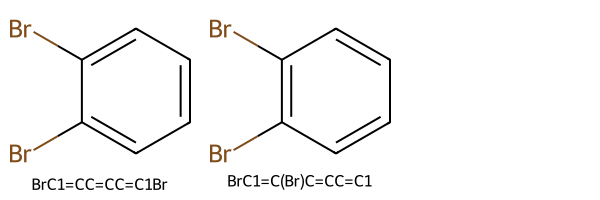

In [36]:
smls_aromatic_equivalent = ["C1=C(Br)C(Br)=CC=C1", "C1C(Br)=C(Br)C=CC=1"]
mols_aromatic_equivalent_unsanitized = [Chem.MolFromSmiles(sml, sanitize=False) for sml in smls_aromatic_equivalent]
canon_smls_aromatic_equivalent_unsanitized = [Chem.MolToSmiles(mol) for mol in mols_aromatic_equivalent_unsanitized]
Draw.MolsToGridImage(mols_aromatic_equivalent_unsanitized, legends=canon_smls_aromatic_equivalent_unsanitized)

and the two canonical SMILES are not the same

In [37]:
canon_smls_aromatic_equivalent_unsanitized[0] == canon_smls_aromatic_equivalent_unsanitized[1]

False

whereas if we do sanitize them, we get the same structure and canonical SMILES:

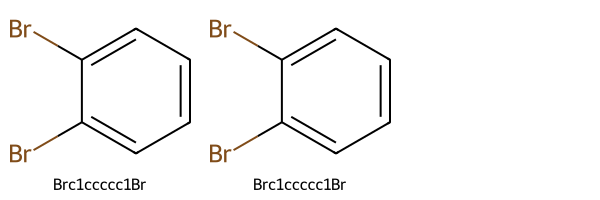

In [38]:
mols_aromatic_equivalent_sanitized = [Chem.MolFromSmiles(sml, sanitize=True) for sml in smls_aromatic_equivalent]
canon_smls_aromatic_equivalent_sanitized = [Chem.MolToSmiles(mol) for mol in mols_aromatic_equivalent_sanitized]
Draw.MolsToGridImage(mols_aromatic_equivalent_sanitized, legends=canon_smls_aromatic_equivalent_sanitized)

In [39]:
canon_smls_aromatic_equivalent_sanitized[0] == canon_smls_aromatic_equivalent_sanitized[1]

True

So the slight differences in the number of different structures as determined by RDKit compared to the tool used by Nicklaus and team (presumably their CACTVS tool) are probably due to the algorithms used to determine the molecular graph (from the input SMILES or other identifier) and then the canonical SMILES. Inspection by chemists of individual pairs would probably lead to better agreement of whether two similar structures are different, but the automatic adjudication required for large datasets is undoubtedly challenging to encode in an algorithm.

### InChI incorporating multiple tautomers 

["InChI is in principle designed to be tautomer-invariant"](https://cactus.nci.nih.gov/presentations/NIHInChI_2021-03/Day_1_Nicklaus_Tautomerism_2021-03-21A.pdf), meaning tautomers of a structure should be assigned the same InChI. Let's check the magnitude of that effect by performing the same operations we did on the SMILES columns  (melting and removing duplicates), but using the InChI columns, and determining how many InChI are required to represent the structures.

In [40]:
df_melted_InChI = df.melt(id_vars=["Ref"], value_vars=cs.starts_with("Std_InChI_"), value_name="InChI")

# Keep rows where InChI is supplied
df_melted_InChI = df_melted_InChI.filter(pl.col('InChI').is_not_null())

# Remove InChI_n label column (n = 1-5)
df_melted_InChI = df_melted_InChI.drop("variable")

# Remove duplicate rows
df_melted_InChI = df_melted_InChI.unique()
unique_InChI = df_melted_InChI.shape[0]
df_melted_InChI

Ref,InChI
i64,str
26,"""InChI=1S/C19H1…"
38,"""InChI=1S/C15H1…"
41,"""InChI=1S/C10H8…"
42,"""InChI=1S/C10H1…"
43,"""InChI=1S/C17H1…"
47,"""InChI=1S/C10H8…"
51,"""InChI=1S/C11H1…"
64,"""InChI=1S/C18H1…"
67,"""InChI=1S/C16H1…"


So 3464 InChI are required to represent the 1776 sets of tautomers, whereas 3911 SMILES were. Let's check how well InChI does at representing multiple tautomers with a single identifier (InChI), compared to SMILES which does not have that goal or capability:

In [41]:
round(unique_InChI/Ref_count, 2)

1.95

In [42]:
round(unique_sml/Ref_count, 2)

2.2

In [43]:
# Calculate percent reduction
f"{(unique_sml - unique_InChI) / unique_sml:.0%}"

'11%'

So on average 1.95 InChI can represent a set of tautomers, compared to 2.2 SMILES, or an 11% reduction. Should InChI achieve its goal of being tautomer invariant, it would presumably require only one InChI for a set of tautomers, which would be 1776 here. Nicklaus and others are working "[Toward a Comprehensive Treatment of Tautomerism in Chemoinformatics Including in InChI V2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8459712/)".

## Enumerating tautomers

Let's start enumerating tautomers using two RDKit algorithms. We'll define a function to create tautomers for a given enumerator class.

In [44]:
def tauts_as_sml_list(
        enumerator: Callable,
        sml: str,
    ) -> list[str]:
    """Use a tautomer enumerator to find the tautomers for a given SMILES
    
    :param enumerator: The tautomer enumerator class, which has an Enumerate method
    :param mol: An RDKit molecule
    :returns: A list of SMILES
    """
    mol = mol_from_sml(sml)
    tauts = enumerator.Enumerate(mol)
    tauts_as_sml_list = []
    for taut in tauts:
        tauts_as_sml_list.append(Chem.MolToSmiles(taut))
    
    # Make smls into a set to remove duplicates, then back into a list so can be in dataframe
    tauts_as_sml_list = list(set(tauts_as_sml_list))
    return tauts_as_sml_list

Now comes the computationally-intensive step of enumerating tautomers for each experimental structure (SMILES) using the two RDKit tautomer enumerators:

- TautomerEnumerator, the default class, which will also be our baseline
- GetV1TautomerEnumerator, the previous version

This step takes about 1.5 minutes on my laptop.

In [45]:
# Enumerate tautomers--this may take more than one minute
enumerators = [rdMolStandardize.TautomerEnumerator, rdMolStandardize.GetV1TautomerEnumerator]
for i, enumerator in enumerate(enumerators):
    df_melted = df_melted.with_columns(
        [
            pl.col("canon_sml").map_elements(lambda s: tauts_as_sml_list(enumerator(), s)).alias(f"tauts_{enumerator.__name__}"),
        ]
    )

In [46]:
df_melted.head(3)

Ref,sml,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator
i64,str,str,list[str],list[str]
33,"""O=C1C=CC=CC=C1…","""O=c1cccccc1Nn1…","[""Oc1cccccc1=Nn1cccc1"", ""O=c1cccccc1Nn1cccc1"", ""O=C1CC=CC=CC1=Nn1cccc1""]","[""O=c1cccccc1Nn1cccc1"", ""Oc1cccccc1=Nn1cccc1""]"
34,"""O=C1C=CC=CC=C1…","""O=c1cccccc1Nn1…","[""O=C1CC=CC=CC1=Nn1cncn1"", ""O=c1cccccc1Nn1cncn1"", ""Oc1cccccc1=Nn1cncn1""]","[""O=c1cccccc1Nn1cncn1"", ""Oc1cccccc1=Nn1cncn1""]"
83,"""NC(C1=NC(C)(C)…","""CC1(C)N=C(C(N)…","[""CC1(C)N=C(C(=N)O)c2ncn(-c3ccccc3)c2N1"", ""CC1(C)N=c2c(ncn2-c2ccccc2)=C(C(=N)O)N1"", … ""CC1(C)N=c2c(ncn2-c2ccccc2)=C(C(N)=O)N1""]","[""CC1(C)N=C(C(=N)O)c2ncn(-c3ccccc3)c2N1"", ""CC1(C)N=c2c(ncn2-c2ccccc2)=C(C(=N)O)N1"", … ""CC1(C)N=c2c(ncn2-c2ccccc2)=C(C(N)=O)N1""]"


## Entering tautomers generated by external algorithms

For the NIH CACTUS Tautomerizer and CACTVS, I don't have programmatic access, so tautomers for some Refs are given below, either directly or read from a file.

### NIH Tautomerizer

In [47]:
# Manually list tautomers created by NIH Tautomerizer
# https://cactus.nci.nih.gov/cgi-bin/tautomerize.tcl
# Settings:
#   steps: multi
#   Predicted tautomers by: All Rules
nih_sml_tauts = {
    "COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O": [
        "COC4=C1[C@H](C(=C6C2=C5C(=C3C(=C12)C(=C(C=C3OC)O)C4=O)C(=CC(=C5C(=C6OC)O)O)OC)[C@H](C)O)[C@H](C)O",
        "COC1=C(C2=C(C=C(C3=C5C(=CC(=C6C(=C(C4=C([C@H](C)O)C(=C1C(=C23)C4=C56)[C@H](C)O)OC)O)O)OC)OC)O)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC3=C2[C@H]([C@@H](C1=C(OC)C(=C6C5=C1C2=C4C(=C3O)C(C=C(C4=C5C(=CC6=O)OC)OC)=O)O)[C@H](C)O)[C@H](C)O",
        "COC2=C3[C@H]([C@@H](C4=C(OC)C(=O)C6=C5C(=C1C(C(=C(C=C1OC)O)C2=O)C3=C45)C(=CC6=O)OC)[C@H](C)O)[C@H](C)O",
        "COC6=C1[C@H]([C@@H](C5=C3C1=C2C(=C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C1[C@H]([C@@H](C5C3=C1C2=C(C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
    ],
    "CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1": [
        "CSC1=NC(=C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=N2)C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=C)N2",
        "CSC1=NC(C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)=C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(=C(O)OC(C)C)C(=N2)C",
        "CSC1NC(=C(C(=N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C",
        "CSC2=NC(=C1C(C=CC=C1)=[N+]([O-])O)C(=C(C)N2)C(=O)OC(C)C",
        "CSC2=NC(=C1C(=CCC=C1)[N+]([O-])=O)C(=C(C)N2)C(=O)OC(C)C",
    ],
    # 457a
    "[2H]Oc1ccc(-c2oc3c([2H])c(O[2H])c(OC)c(=O)c-3c(O[2H])c2O[2H])cc1O[2H]": [
        # 2 tautomer(s) generated using PT_02_00 - 1,5 (thio)keto/(thio)enol
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=C(OC)C3=O)O[2H])[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])O[2H]",
        # 9 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
        "O=C1C(C=C(C=C1)C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(C(C(C(=C2O3)[2H])=O)(OC)[2H])=O)O[2H])O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3(C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])=O)[2H])O[2H]",
        "O([2H])C1(C(C=C(C=C1)C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])=O)[2H]",
        "O=C1C(C=C(C=C1)C3=C(C(=C2C(C(C(C(=C2O3)[2H])=O)(OC)[2H])=O)O[2H])O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C3(C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])=O)[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2(C(C(C(C(=C2O3)[2H])=O)(OC)[2H])=O)[2H])=O)O[2H])O[2H]",
        # 2 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(=C(C(C(=C2O3)[2H])=O)OC)O[2H])O[2H])O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2=C(C(=C(C(=C2O3)[2H])O[2H])OC)O[2H])=O)O[2H])O[2H]",
        # 2 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
        "O=C1C(=CC(=CC1[2H])C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])O[2H]",
        "O([2H])C3=CC=C(C2=C(C(=C1C(C(=C(C(=C1O2)[2H])O[2H])OC)=O)O[2H])O[2H])C(C3=O)[2H]",
        # 1 tautomer(s) generated using PT_11_00 - 1,11 (aromatic) heteroatom H shift
        "O=C1C(=CC(C=C1)=C3C(=C(C2=C(C(=C(C(=C2O3)[2H])O[2H])OC)O[2H])O[2H])O[2H])O[2H]",
        # 1 tautomer(s) generated using PT_11_02 - 1,15 (aromatic) heteroatom H shift
        "O=C1C(=CC(C=C1)=C2C(=C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])O[2H])O[2H])O[2H]",
    ],
    # 457b
    "[2H]Oc1ccc(-c2oc3c([2H])c(O[2H])c(OC)c(O[2H])c3c(=O)c2O[2H])cc1O[2H]": [
        # 9 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
        "O=C1C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=O)C(=C3O[2H])OC)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(OC)(C3=O)[2H])[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C2(C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)=O)[2H])O[2H]",
        "O([2H])C1(C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])=O)[2H]",
        "O=C1C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=O)C(=C3O[2H])OC)[2H])=O)O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(OC)(C3=O)[2H])[2H])=O)O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C2(C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)=O)[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=O)C(OC)(C3=O)[2H])[2H])=O)O[2H])O[2H]",
        # 7 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
        "O=C1C(=CC(=CC1[2H])C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(=C(C(C(=C2O3)[2H])=O)OC)O[2H])O[2H])O[2H])O[2H]",
        "O([2H])C3=CC=C(C1=C(C(C2=C(O1)C(=C(O[2H])C(=C2O[2H])OC)[2H])=O)O[2H])C(C3=O)[2H]",
        "O=C1C(=CC(=CC1[2H])C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])O[2H]",
        "O=C1C(=CC(=CC1[2H])C3=C(C(=C2C(=C(C(C(=C2O3)[2H])=O)OC)O[2H])O[2H])O[2H])O[2H]",
        "O=C1C(=CC(C=C1[2H])=C2C(=C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])O)O[2H])O[2H]",
        # 1 tautomer(s) generated using PT_10_00 - 1,9 (aromatic) heteroatom H shift
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])O[2H]",
    ],
    # 890a
    "COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54": [
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2=C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(C2=C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC6=C(O)C1=C(O)C=C(OC)C2=C1C(=C3C(=C(C(=C4C(C=C(C2=C34)OC)=O)O)OC)C[C@H](C)OC(=O)C5=CC=C(C=C5)O)C6=C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C(CC(C(=C34)C5=O)=O)OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2=C1C(=C(OC)CC2=O)C5=C3C(=C4O)C(=O)C=C5OC)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(C(=C(C2=C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)O)O)OC)=C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(O)=C6C=CC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(=O)C=C6)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC2=C(C3=C1C(=C(C(C5=C1C(=C4C(=CC(C(=C2O)C34)=O)OC)C(=CC5=O)OC)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC3=C(C1=C4C(=C(C(=C5C(C=C(C(=C2C(=CC(C(=C12)C3=O)=O)OC)C45)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
    ],
    # 890b
    #   3 tautomer(s) generated using PT_02_00 - 1,5 (thio)keto/(thio)enol
    #   7 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   3 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
    #   6 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    "COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43": [
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(=C(C(C3=C45)=C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)O)O)OC)OC)O)C7=O",
        "COC5=C(C3=C(C=C(C4=C1C(=CC(=C2C(C(=C(C(=C12)C(=C34)C5=C[C@@H](C)OC(=O)C6=CC=CC=C6)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC)OC)O)O",
        "COC5=C(C3=C(C=C(C4=C1C(=CC(=C2C(=C(C(C(=C12)C(=C34)C5=C[C@@H](C)OC(=O)C6=CC=CC=C6)=C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)O)O)OC)OC)O)O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)=O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)=O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)=O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)=O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5=C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)O)=O)OC)OC)O)C7=O",
        "COC2=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C4=C3C(=C2O)C(C=C(C3=C5C(=CC(=C6C(C(=C(C4=C56)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC)OC)=O",
        "COC2=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C4=C3C(=C2O)C(C=C(C3=C5C(=CC(C6=C(C(=C(C4=C56)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)O)=O)OC)OC)=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(O)=C6C=CC(C=C6)=O)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(=O)C=C6)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C5=C2C4=C(C(C(=C2C[C@H](C)OC(=O)C3=CC=C(C=C3)O)OC)=O)C(=O)C=C(OC)C4=C6C5C(=C(C=C6OC)O)C7=O",
        "COC4=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C2=C6C5C(=C3C2=C(C(C=C3OC)=O)C4=O)C(=CC(=C5C(C(=C6C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C5=C2C4=C(C(C(=C2C[C@H](C)OC(O)=C3C=CC(C=C3)=O)OC)=O)C(=O)C=C(OC)C4=C6C5C(=C(C=C6OC)O)C7=O",
        "COC4=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C2=C6C5C(=C3C2=C(C(C=C3OC)=O)C4=O)C(=CC(=C5C(C(=C6C[C@H](C)OC(O)=C7C=CC(C=C7)=O)OC)=O)O)OC",
    ],
    "C=C(OCC)C1N(O)C(C)(C)C(C)=[N+]1[O-]": [
        "C=C(OCC)C1[NH+](C(C(N1O)(C)C)=C)[O-]",
        "C=C(OCC)C1=[N+](C(C(N1O)(C)C)C)[O-]",
        "C=C(OCC)C=[N+]([O-])C(C)(C)C(C)=NO",
    ],
    "CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1": [
        "CC[P](CC)(=NC1C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)=O)C5=CC=CC=C5",
        "CC=[P](CC)(NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O)C5=CC=CC=C5",
        "CC=[P](CC)(NC1C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)=O)C5=CC=CC=C5",
        "CC[P](CC)(=NC1=CC(=CC(C(C)(C)C)C1=O)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C5=CC=CC=C5",
        "CC[P]5(CC)(NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O5)C6=CC=CC=C6",
    ],
    # ***891***
    # 1512a
    #   1 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    #   1 tautomer(s) generated using RC_12_00 - 5_endo_tet or iminophosphorane/benzoxazaphospholine
    "CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1": [
        "CC[P]2(OC1C(=CC(=CC1=N2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)(CC)C6=CC=CC=C6",
        "CC[P]2(OC1=C(C=C(CC1=N2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)(CC)C6=CC=CC=C6",
        "CC[P](CC)(C1=CC=CC=C1)=NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O",
    ],
    # 1512b
    #   3 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    #   1 tautomer(s) generated using RC_12_00 - 5_endo_tet or iminophosphorane/benzoxazaphospholine
    # 1688a
    #   1 tautomer(s) generated using PT_03_00 - simple (aliphatic) imine
    #   2 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_16_00 - nitroso/oxime
    #   1 tautomer(s) generated using PT_36_00 - oxime/nitrone: 1,2 H-shift
    #   1 tautomer(s) generated using RC_22_00 - 5_endo_trig: 1,5 H-shift
    "C=C(/C=[N+](\[O-])C(C)(C)/C(C)=N/O)OCC": [
        "C=C(\C=[N+](/[O-])C(C)(C)C(=C)NO)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)N=O)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(=C)NO)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)N=O)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)=[NH+][O-])OCC",
        "C=C(C1N(O)C(C)(C)C(=[N+]1[O-])C)OCC",
    ],
    # 1688b
    #   1 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_39_00 - nitrone/azoxy or Behrend rearrangement
    #   1 tautomer(s) generated using RC_22_00 - 5_endo_trig: 1,5 H-shift
    # 1704 a
    "Cc1cc(C=O)c(C)c(C=O)c1": [
        "CC1=CC(C(C(=C1)C=O)=C)=CO",
        "C[CH]1C=C([C](C(=C1)C=O)=[CH2])C=O",
    ],
    # 1704 b
    "C=c1c(C=O)cc(C)cc1=CO": [
        "[CH2]=[C]1C(=C[CH](C=C1C=O)C)C=O",
        "CC1=C(C=C(C=C1C=O)C)C=O",
        "C=C1C(C=C(C=C1C=O)C)C=O",
        "C=C1C(=CC(=CC1C=O)C)C=O",
        "[CH2]=[C]1C(=C[CH](C=C1C=O)C)C=O",
        "CC1=C(C=C(C=C1C=O)C)C=O",
    ],
}

In [48]:
# Function to canonicalize a list of SMILES
def canonicalize_smiles(smls_list: list[str]) -> list[str]:
    """
    Canonicalize a list of SMILES, trying first with and then without sanitization;
    convert list into a set to remove duplicates, then back to a list so can go in dataframe

    :param smls_list: List of SMILES strings
    :returns: List of canonical SMILES strings
    """
    canonical_smiles = []
    for sml in smls_list:
        mol = Chem.MolFromSmiles(sml)
        if mol:
            canonical = Chem.MolToSmiles(mol)
            canonical_smiles.append(canonical)
        else:
            mol = Chem.MolFromSmiles(sml, sanitize=False)
            if mol:
                canonical = Chem.MolToSmiles(mol)
                canonical_smiles.append(canonical)
            else:
                # canonical_smiles.append(None) #? This shouldn't be here, correct?
                print("Molecule couldn't be created")
    # Eliminate duplicates by turning list into a set, then back to a list so can go in dataframe
    canonical_smiles_unique = list(set(canonical_smiles))
    return canonical_smiles_unique

In [49]:
# Prepare tautomer data from NIH web site
nih_sml_tauts_canon = {key: canonicalize_smiles(value) for key, value in nih_sml_tauts.items()}
nih_inputs = nih_sml_tauts_canon.keys()
nih_tauts = nih_sml_tauts_canon.values()
df_nih = pl.DataFrame({"canon_sml": nih_inputs, "tauts_NIH": nih_tauts})
df_nih

canon_sml,tauts_NIH
str,list[str]
"""COc1c2c3c4c(c(…","[""COC1=C2c3c4c(c(O)cc(OC)c4c4c(OC)cc(O)c5c(O)c(OC)c(c3c54)=C([C@H](C)O)[C@@H]2[C@H](C)O)C1=O"", ""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c1c4C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O"", … ""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c(O)c(OC)c6c([C@H](C)O)c([C@H](C)O)c1c(c23)c6c54""]"
"""CSC1=NC(c2cccc…","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", ""CSC1N=C(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]"
"""[2H]Oc1ccc(-c2…","[""[2H]Oc1c(C2=CC([2H])(O[2H])C(=O)C=C2)oc2c([2H])c(O[2H])c(OC)c(=O)c-2c1O[2H]"", ""[2H]Oc1c(C2=CC(=O)C([2H])(O[2H])C=C2)oc2c([2H])c(O[2H])c(OC)c(=O)c-2c1O[2H]"", … ""[2H]OC1=C(C2=CC([2H])(O[2H])C(=O)C=C2)OC2=C([2H])C(O[2H])=C(OC)C(=O)C2([2H])C1=O""]"
"""[2H]Oc1ccc(-c2…","[""[2H]OC1=C([2H])c2oc(C3=CC([2H])(O[2H])C(=O)C=C3)c(O[2H])c(=O)c2C(=O)C1([2H])OC"", ""[2H]OC1=CC(=C2Oc3c([2H])c(O[2H])c(OC)c(O[2H])c3C(O)=C2O[2H])C=C([2H])C1=O"", … ""[2H]OC1=CC(c2oc3c([2H])c(O[2H])c(OC)c(O[2H])c3c(=O)c2O[2H])=CC([2H])C1=O""]"
"""COc1c(O)c2c(=O…","[""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c1c32)C(OC)=CC(=O)C5C(=O)C(OC)=C4C[C@H](C)OC(=O)c1ccc(O)cc1"", ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c(c(O)c(OC)c(C[C@H](C)OC(=O)c4ccc(O)cc4)c32)C(=O)C=C1OC"", … ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c1c32)C(OC)=CC(=O)C5C(=O)C(OC)=C4C[C@H](C)OC(=O)C1=CCC(=O)C=C1""]"
"""COc1c(C[C@@H](…","[""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(O)=C4C(=O)C(OC)=C(C[C@H](C)OC(O)=C5C=CC(=O)C=C5)C(=C3C(C[C@@H](C)OC(=O)c3ccccc3)=C(OC)C2=O)C41"", ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c1c32)C(OC)=CC(=O)C5C(=O)C(OC)=C4C[C@H](C)OC(=O)c1ccc(O)cc1"", … ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c1c32)C(OC)=CC(=O)C5C(=O)C(OC)=C4C[C@H](C)OC(=O)C1=CCC(=O)C=C1""]"
"""C=C(OCC)C1N(O)…","[""C=C(OCC)C1N(O)C(C)(C)C(=C)[NH+]1[O-]"", ""C=C(C=[N+]([O-])C(C)(C)C(C)=NO)OCC"", ""C=C(OCC)C1=[N+]([O-])C(C)C(C)(C)N1O""]"
"""CCP(CC)(=Nc1cc…","[""CCP(CC)(=NC1C=C(C(c2ccccc2)(c2ccccc2)c2ccccc2)C=C(C(C)(C)C)C1=O)c1ccccc1"", ""CC=P(CC)(Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", … ""CCP(CC)(=NC1=CC(C(c2ccccc2)(c2ccccc2)c2ccccc2)=CC(C(C)(C)C)C1=O)c1ccccc1""]"
"""CCP1(CC)(c2ccc…","[""CCP1(CC)(c2ccccc2)N=C2CC(C(c3ccccc3)(c3ccccc3)c3ccccc3)=CC(C(C)(C)C)=C2O1"", ""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", ""CCP1(CC)(c2ccccc2)N=C2C=C(C(c3ccccc3)(c3ccccc3)c3ccccc3)C=C(C(C)(C)C)C2O1""]"


Now we merge in the NIH tautomers by left-joining on canonical SMILES.

In [50]:
# Ensure no tautsNIH columns already exist--can cause additional column tautsNIH_right to be created
df_melted = df_melted.drop(cs.starts_with('tauts_NIH'))

df_melted = df_melted.join(df_nih, on="canon_sml", how="left")

To inspect the results and check which Refs are included, let's display one row for each Ref.

In [51]:
df_melted.filter(pl.col("tauts_NIH").is_not_null()).unique(subset="Ref").sort("Ref")

Ref,sml,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH
i64,str,str,list[str],list[str],list[str]
73,"""O=[N+](C1=C(C2…","""CSC1=NC(c2cccc…","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""]","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", ""CSC1N=C(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]"
457,"""O=C(C(OC)=C(C(…","""[2H]Oc1ccc(-c2…","[""[2H]OC1=CC(c2oc3c([2H])c([OH][2H])c(OC)c(O)c3c(=O[2H])c2O[2H])=CCC1=O[2H]"", ""[2H]OC1=CC=C(C2=C(O[2H])C([OH][2H])=C3C(=O)C(OC)C(=O[2H])C([2H])=C3O2)CC1=O[2H]"", … ""[2H]Oc1c2c(oc(=C3CCC(=O[2H])C(=O[2H])C3)c1=O[2H])=C([2H])C(=O[2H])C(OC)=C2O""]","[""[2H]Oc1c2c(oc(=C3C=CC([OH][2H])C(=O[2H])C3)c1=O[2H])=C([2H])C([OH][2H])=C(OC)C2=O"", ""[2H]OC1=CC(c2oc3c([2H])c([OH][2H])c(OC)c(O)c3c(=O[2H])c2O[2H])=CCC1=O[2H]"", … ""[2H]OC1=C2C(O)=C(OC)C(=O[2H])C([2H])=C2OC(=C2C=CC(=O[2H])C([OH][2H])=C2)C1[OH][2H]""]","[""[2H]Oc1c(C2=CC([2H])(O[2H])C(=O)C=C2)oc2c([2H])c(O[2H])c(OC)c(=O)c-2c1O[2H]"", ""[2H]Oc1c(C2=CC(=O)C([2H])(O[2H])C=C2)oc2c([2H])c(O[2H])c(OC)c(=O)c-2c1O[2H]"", … ""[2H]OC1=C(C2=CC([2H])(O[2H])C(=O)C=C2)OC2=C([2H])C(O[2H])=C(OC)C(=O)C2([2H])C1=O""]"
888,"""O=C1C(C(O)=C2)…","""COc1c2c3c4c(c(…","[""COC1=C2c3c4c5c(c(O)cc(OC)c5c5c3=C(C(=O)CC=5OC)C1=O)C(=O)C(OC)C4=C([C@H](C)O)C2[C@H](C)O"", ""COC1=c2c3c4c5c(c([C@H](C)O)c([C@H](C)O)c6c5c2=C(C(=O)C1)C(=O)C6OC)C(OC)C(=O)C=4C(=O)CC=3OC"", … ""COC1=C2c3c4c5c(c6c3=C(C(=O)CC=6OC)C1=O)=C(OC)CC(=O)C=5C(=O)C(OC)C4=C([C@H](C)O)C2[C@H](C)O""]","[""COC1=C(O)C2C(O)=CC(OC)=c3c4c5c6c(c(=C(C)O)c(C(C)=O)c1c6c32)C(OC)C(O)=C5C(=O)CC4OC"", ""COC1=CC(=O)C2C(=O)C(OC)c3c(C(C)O)c(C(C)O)c4c(OC)c(O)c5c(O)cc(OC)c6c1c2c3c4c56"", … ""COC1=c2c3c4c(c(C(C)=O)c(C(C)O)c5c(OC)c(O)c6c(c2C(OC)CC=6O)c54)=C(OC)C(=O)C3=C(O)C1""]","[""COC1=C2c3c4c(c(O)cc(OC)c4c4c(OC)cc(O)c5c(O)c(OC)c(c3c54)=C([C@H](C)O)[C@@H]2[C@H](C)O)C1=O"", ""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c1c4C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O"", … ""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c(O)c(OC)c6c([C@H](C)O)c([C@H](C)O)c1c(c23)c6c54""]"
890,"""O=C(C=C1OC)C2=…","""COc1c(O)c2c(=O…","[""COC1=CC(=O)C2=c3c1c1c(OC)cc(O)c4c(O)c(OC)c(=C[C@@H](C)OC(=O)c5ccccc5)c(c3=C(C[C@H](C)OC(=O)C3=CCC(=O)C=C3)C(OC)C2=O)c41"", ""COC1=CC(=O)C2=c3c1c1c(OC)cc(O)c4c(O)c(OC)c(=C[C@H](C)OC(=O)C5C=CC(=O)C=C5)c(c3=C(C[C@@H](C)OC(=O)c3ccccc3)C(OC)C2=O)c41"", … ""COC1=CC(=O)C2=c3c1c1c(OC)cc(=O)c4c(=O)c(OC)c(C[C@@H](C)OC(=O)c5ccccc5)c(c3C(C[C@H](C)OC(O)=C3C=CC(=O)C=C3)C(OC)C2=O)c1=4""]","[""COC1=c2c3c(c(=O)c(OC)c(C[C@H](C)OC(=O)C4=CCC(=O)C=C4)c3c3c(C[C@@H](C)OC(=O)c4ccccc4)c(OC)c(=O)c4c(O)cc(OC)c2c43)C(=O)C1"", ""COC1=C(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(c(O)cc(OC)c3c3c4c(c(O)c(OC)c(=C[C@H](C)OC(=O)C5C=CC(=O)C=C5)c24)C(=O)CC=3OC)C1=O"", … ""COC1=C(C[C@H](C)OC(=O)C2C=CC(=O)C=C2)c2c3c(c(O)cc(OC)c3c3c(OC)cc(O)c4c(O)c(OC)c(=C[C@@H](C)OC(=O)c5ccccc5)c2c43)C1=O""]","[""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c1c32)C(OC)=CC(=O)C5C(=O)C(OC)=C4C[C@H](C)OC(=O)c1ccc(O)cc1"", ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c(c(O)c(OC)c(C[C@H](C)OC(=O)c4ccc(O)cc4)c32)C(=O)C=C1OC"", … ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c1c32)C(OC)=CC(=O)C5C(=O)C(OC)=C4C[C@H](C)OC(=O)C1=CCC(=O)C=C1""]"
1512,"""[H]OC1=C(C=C(C…","""CCP(CC)(=Nc1cc…","[""CCP(CC)(=NC1=CC(C(c2ccccc2)(c2ccccc2)c2ccccc2)=CC(C(C)(C)C)C1=O)c1ccccc1"", ""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1""]","[""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1""]","[""CCP(CC)(=NC1C=C(C(c2ccccc2)(c2ccccc2)c2ccccc2)C=C(C(C)(C)C)C1=O)c1ccccc1"", ""CC=P(CC)(Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", … ""CCP(CC

Now let's merge the several rows for each Ref by putting the tautomers into lists.

In [93]:
df_melted_aggregated = (
    # Aggregate by combining multiple lists into a single flat list
    df_melted.group_by('Ref')
    .agg(["canon_sml", cs.starts_with("tauts_").explode()])
# Keep the unique elements in each list; that is, remove duplicates
).with_columns(cs.starts_with("tauts_").list.unique())
df_melted_aggregated.filter(pl.col("Ref").is_in([1712, 1343, 1704]))

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH
i64,list[str],list[str],list[str],list[str]
1343,"[""O=C(/C(=C\Nc1ccc(C(F)(F)F)cc1)c1ccccc1)c1ccccc1"", ""O/C(=C(\C=Nc1ccc(C(F)(F)F)cc1)c1ccccc1)c1ccccc1""]","[""O=C(C(=CNc1ccc(C(F)(F)F)cc1)c1ccccc1)c1ccccc1"", ""O=C(c1ccccc1)C(C=Nc1ccc(C(F)(F)F)cc1)c1ccccc1"", ""OC(=C(C=Nc1ccc(C(F)(F)F)cc1)c1ccccc1)c1ccccc1""]","[""OC(=C(C=Nc1ccc(C(F)(F)F)cc1)c1ccccc1)c1ccccc1"", ""O=C(c1ccccc1)C(C=Nc1ccc(C(F)(F)F)cc1)c1ccccc1"", ""O=C(C(=CNc1ccc(C(F)(F)F)cc1)c1ccccc1)c1ccccc1""]",[null]
1712,"[""O=C1C=CC(Cl)S1"", ""O=C1CC=C(Cl)S1""]","[""O=C1CC=C(Cl)S1"", ""O=C1C=CC(Cl)S1"", ""Oc1ccc(Cl)s1""]","[""Oc1ccc(Cl)s1"", ""O=C1C=CC(Cl)S1"", ""O=C1CC=C(Cl)S1""]",[null]
1704,"[""Cc1cc(C=O)c(C)c(C=O)c1"", ""C=c1c(C=O)cc(C)cc1=CO""]","[""Cc1cc(C=O)c(C)c(C=O)c1"", ""C=c1c(C=O)cc(C)cc1=CO"", ""C=C1C(C=O)=CC(C)=CC1C=O""]","[""Cc1cc(C=O)c(C)c(C=O)c1"", ""C=c1c(C=O)cc(C)cc1=CO""]","[""C=c1c(C=O)cc(C)cc1=CO"", ""C=C1C(C=O)=CC(C)C=C1C=O"", … ""C=C1C(C=O)=CC(C)=CC1C=O""]"


### CACTVS

The CACTVS results provided by Marc Nicklaus are in [SDF (structure-data format)](https://en.wikipedia.org/wiki/Chemical_table_file#SDF), so this function extracts the Ref and number (1 or 2, used to identify different experimentally-observed structures).

In [94]:
def extract_ref(
    e_name: str,
):
    """Extract the reference number from an E_NAME entry in an SDF file, for example
    > <E_NAME>
    Ref_0890_01_1
    has e_name of
    Ref_0890_01_1
    which returns
    890

    :param e_name: The E_NAME property, for example "Ref_0890_01_1"
    """
    parts = e_name.split("_")
    ref_str = parts[1]
    try:
        ref = int(ref_str)
    except:
        ref = None
    return ref

This code actually reads the SDF files into lists.

In [95]:
files = ['Refs', 'Ref_0467_expanded17', 'Ref_0890_different_expanded14c', 'Ref_0891_expanded17']

refs_cactvs = []
nums_cactvs = []
tauts_cactvs = []

for file in files:
    # Iterate through the molecules in the SDF file
    cactvs = Chem.SDMolSupplier(f'../data/{file}.sdf')
    last_num = None
    for mol in cactvs:
        if mol is not None:
            ref = extract_ref(mol.GetProp("E_NAME"))
            sml = mol.GetProp("E_SMILES")
            refs_cactvs.append(ref)
            tauts_cactvs.append(sml)

We then put those lists into another Polars dataframe.

In [96]:
df_cactvs = pl.DataFrame({"Ref": refs_cactvs, "tauts_CACTVS": tauts_cactvs})

To inspect the results and check which Refs are included, let's display one tautomer for each Ref.

In [97]:
df_cactvs.unique(subset=["Ref"]).sort("Ref")

Ref,tauts_CACTVS
i64,str
467,"""O=c1cc(O)cc2oc…"
890,"""COC2C(O)C4C(=O…"
891,"""COc1c(O)c2c(=O…"
1512,"""CC[P]6(CC)(C1=…"
1704,"""CC1=CC(=C(C(=C…"


Now we can merge in the CACTVS tautomers by joining two dataframes.

In [98]:
# Ensure no CACTVS columns already exist--if one does, it can cause additional column _right to be created
df_melted_aggregated = df_melted_aggregated.drop(cs.contains("CACTVS"))

# Merge in CACTVS tauts by left-joining on Ref, then aggregate tautCACTVS into a list
df_melted_aggregated = df_melted_aggregated.join(df_cactvs, on="Ref", how="left").group_by('Ref').agg(pl.exclude("tauts_CACTVS").first(), 'tauts_CACTVS')
df_melted_aggregated.filter(pl.col("Ref").is_in([890, 891]))

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS
i64,list[str],list[str],list[str],list[str],list[str]
891,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H](C(C)=O)C(C)(O)C2""]","[""C=C(O)C1=C2c3c4c5c(c(O)cc(OC)c5c5c(OC)cc(O)c(c35)C(=O)C2OC)C(=O)C(OC)=C4CC1(C)O"", ""C=C(O)C1=C2c3c4c5c(c(O)cc(OC)c5c5c(OC)cc(O)c(c35)C(=O)C2OC)C(=O)C(OC)C4=CC1(C)O"", … ""COC1=C2CC(C)(O)C(C(C)=O)=C3c4c2c2c(c(O)cc(OC)c2c2c4=C(C(=O)CC=2OC)C(=O)C3OC)C1=O""]","[""C=C(O)C1=C2c3c4c(c5c6c3C(=CC1(C)O)C(OC)C(=O)C6C(=O)C=C5OC)C(OC)=CC(=O)C4=C(O)C2OC"", ""COC1=C2C(=C(C)O)C(C)(O)Cc3c(OC)c(=O)c4c(=O)cc(OC)c5c6c(c2c3c5=4)=C(C1=O)C(O)=CC6OC"", … ""COC1=C2CC(C)(O)C(C(C)=O)c3c(OC)c(=O)c4c(=O)cc(OC)c5c6c(c2c3c5=4)=C(C(=O)CC6OC)C1=O""]",[null],"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54"", ""COC6=C1C4=C2C(=C(C(C1)(C)O)C(C)=O)C(=C(C3=C(C=C(C(=C23)C5=C4C(=C(O)C=C5OC)C6=O)OC)O)O)OC"", … ""COC4=C6C2=C1C(C(OC)C(=O)C5=C1C(=C3C(=CC(=O)C(=C23)C4=O)OC)C(=CC5=O)OC)C(=C(C)O)C(C)(O)C6""]"
890,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43""]","[""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c1c3C(C[C@H](C)OC(O)=C1C=CC(=O)C=C1)=C(OC)C2=O"", ""COC1=CC(=O)C2C(O)=C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c3C(C[C@H](C)OC(=O)C3C=CC(=O)C=C3)=C(OC)C(=O)C=2C(=O)CC=1OC"", … ""COC1=CC(=O)C2=C(O)C(OC)C(=C[C@H](C)OC(=O)C3=CCC(=O)C=C3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21""]","[""COC1=CC(=O)C2C(O)=C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@H](C)OC(O)=C4C=CC(=O)C=C4)c3c21"", ""COC1=CC(=O)C2=c3c1c1c(OC)cc(O)c4c(O)c(OC)c(=C[C@H](C)OC(=O)C5=CCC(=O)C=C5)c(c3=C(C[C@@H](C)OC(=O)c3ccccc3)C(OC)C2=O)c41"", … ""COC1=C(O)c2c(=O)cc(OC)c3c2c(c2c(=C[C@H](C)OC(=O)C4C=CC(=O)C=C4)c(OC)c(O)c4c(=O)cc(OC)c3c42)C1C[C@@H](C)OC(=O)c1ccccc1""]","[""COC1=C(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(c(O)cc(OC)c3c3c(OC)cc(O)c4c(O)c(OC)c(=C[C@H](C)OC(=O)c5ccc(O)cc5)c2c43)C1=O"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", … ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c1c3C(C[C@H](C)OC(=O)c1ccc(O)cc1)=C(OC)C2=O""]","[""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=O)C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67"", ""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67)O"", … ""COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7""]"


### Data cleanup

Because we have tautomers for NIH and CACTVS for only certain Refs, we need to remove None entries in lists so that, for example, `[None None]` won't be counted as two tautomers; it will be replaced with `[]` which will be counted as zero tautomers, indicating that we didn't obtain tautomers for that Ref.

In [99]:
# Remove None (null) values in tauts_NIH and tauts_CACTVS lists
for source in ["NIH", "CACTVS"]:
    tauts_source = df_melted_aggregated[f"tauts_{source}"].to_list()
    tauts_source_no_nulls = []
    for tauts_list in tauts_source:
        tauts_list_no_nulls = []
        for taut in tauts_list:
            if taut != None:
                tauts_list_no_nulls.append(taut)
        tauts_source_no_nulls.append(tauts_list_no_nulls)

    tauts_source_no_nulls_series = pl.Series(tauts_source_no_nulls)
    df_melted_aggregated = df_melted_aggregated.with_columns(tauts_source_no_nulls_series.alias(f"tauts_{source}"))

We can tell that worked because we have some `[]` entries in tauts_CACTVS and tauts_NIH.

In [100]:
df_melted_aggregated.head(3)

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS
i64,list[str],list[str],list[str],list[str],list[str]
149,"[""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(=O)c(-c3nc4ccccc4[nH]c3=O)c[nH]c12""]","[""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(=O)c(=C3Nc4ccccc4N=C3O)cnc12"", … ""CCOC(=O)c1cnn2c1N=CC(c1nc3ccccc3[nH]c1=O)C2=O""]","[""CCOC(=O)c1cnn2c(O)c(-c3nc4ccccc4nc3O)cnc12"", ""CCOC(=O)c1cnn2c(=O)c(-c3nc4ccccc4nc3O)c[nH]c12"", … ""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12""]",[],[]
173,"[""O/C=C(/c1ccccc1)c1nc(/C(=C\O)c2ccccc2)nc(/C(=C\O)c2ccccc2)n1"", ""O=CC(=C1NC(=C(C=O)c2ccccc2)NC(=C(C=O)c2ccccc2)N1)c1ccccc1""]","[""O=CC(=C1N=C(C(=CO)c2ccccc2)NC(C(=CO)c2ccccc2)=N1)c1ccccc1"", ""O=CC(=C1N=C(C(=CO)c2ccccc2)NC(=C(C=O)c2ccccc2)N1)c1ccccc1"", … ""O=CC(=C1N=C(C(C=O)c2ccccc2)NC(C(C=O)c2ccccc2)=N1)c1ccccc1""]","[""O=CC(=C1N=C(C(C=O)c2ccccc2)NC(=C(C=O)c2ccccc2)N1)c1ccccc1"", ""O=CC(=C1N=C(C(=CO)c2ccccc2)NC(C(=CO)c2ccccc2)=N1)c1ccccc1"", … ""O=CC(=C1N=C(C(=CO)c2ccccc2)NC(=C(C=O)c2ccccc2)N1)c1ccccc1""]",[],[]
929,"[""CCC(C(=O)CC(=O)CC(=O)OC)C(=O)OC"", ""CCC(C(=O)C/C(O)=C/C(=O)OC)C(=O)OC"", … ""CCC(C(=O)OC)/C(O)=C/C(=O)CC(=O)OC""]","[""CCC(C(O)=CC(O)=CC(=O)OC)=C(O)OC"", ""CCC(C(=O)CC(=O)C=C(O)OC)C(=O)OC"", … ""CCC(C(=O)C=C(O)CC(=O)OC)=C(O)OC""]","[""CCC(C(=O)OC)C(O)=CC(=O)CC(=O)OC"", ""CCC(C(=O)OC)=C(O)C=C(O)CC(=O)OC"", … ""CCC(C(=O)CC(O)=CC(=O)OC)=C(O)OC""]",[],[]


## Convert enumerated tautomers from SMILES to InChI

Now that we've enumerated tautomers, let's convert the SMILES of the RDKit TautomerEnumerator, our default algorithm, to InChI. This will let us check how well InChI does at its stated goal of covering multiple tautomers with a single InChI.

We start by creating a function to return a list of InChI for an iterable of SMILES.

In [101]:
def InChI_smiles(smls_iterable: Iterable[str]) -> Iterable[str]:
    """
    Convert an iterable of SMILES to InChI, returning the list of unique InChI

    :param smls_iterable: Iterable of SMILES strings
    :returns: List of InChI strings
    """
    InChIs = []
    for sml in smls_iterable:
        mol = Chem.MolFromSmiles(sml)
        if mol:
            InChI = Chem.MolToInchi(mol)
            InChIs.append(InChI)
        else:
            mol = Chem.MolFromSmiles(sml, sanitize=False)
            if mol:
                InChI = Chem.MolToInchi(mol)
                InChIs.append(InChI)
            else:
                print("Molecule couldn't be created")
    # Eliminate duplicates by turning list into a set, then back to a list so can go in dataframe
    InChIs_unique = list(set(InChIs))
    return InChIs_unique

Now we determine the list of InChI for the list of tautomers from TautomerEnumerator.

In [102]:
df_melted_aggregated = df_melted_aggregated.with_columns(
    [
        pl.col("tauts_TautomerEnumerator").map_elements(InChI_smiles).alias("tauts_TautomerEnumerator_InChI"),
    ]
)

In [103]:
df_melted_aggregated.filter(pl.col("Ref").is_in([891, 892])).sort(pl.col("Ref"))

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI
i64,list[str],list[str],list[str],list[str],list[str],list[str]
891,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H](C(C)=O)C(C)(O)C2""]","[""C=C(O)C1=C2c3c4c5c(c(O)cc(OC)c5c5c(OC)cc(O)c(c35)C(=O)C2OC)C(=O)C(OC)=C4CC1(C)O"", ""C=C(O)C1=C2c3c4c5c(c(O)cc(OC)c5c5c(OC)cc(O)c(c35)C(=O)C2OC)C(=O)C(OC)C4=CC1(C)O"", … ""COC1=C2CC(C)(O)C(C(C)=O)=C3c4c2c2c(c(O)cc(OC)c2c2c4=C(C(=O)CC=2OC)C(=O)C3OC)C1=O""]","[""C=C(O)C1=C2c3c4c(c5c6c3C(=CC1(C)O)C(OC)C(=O)C6C(=O)C=C5OC)C(OC)=CC(=O)C4=C(O)C2OC"", ""COC1=C2C(=C(C)O)C(C)(O)Cc3c(OC)c(=O)c4c(=O)cc(OC)c5c6c(c2c3c5=4)=C(C1=O)C(O)=CC6OC"", … ""COC1=C2CC(C)(O)C(C(C)=O)c3c(OC)c(=O)c4c(=O)cc(OC)c5c6c(c2c3c5=4)=C(C(=O)CC6OC)C1=O""]",[],"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54"", ""COC6=C1C4=C2C(=C(C(C1)(C)O)C(C)=O)C(=C(C3=C(C=C(C(=C23)C5=C4C(=C(O)C=C5OC)C6=O)OC)O)O)OC"", … ""COC4=C6C2=C1C(C(OC)C(=O)C5=C1C(=C3C(=CC(=O)C(=C23)C4=O)OC)C(=CC5=O)OC)C(=C(C)O)C(C)(O)C6""]","[""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h7-8,18,31,34,36H,9H2,1-6H3"", ""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h7-8,11,29,31,34,36H,1,9H2,2-6H3"", … ""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h7-9,17-18,28,31,35-36H,1H2,2-6H3""]"
892,"[""O=C1C=CC(O)=C2C(=O)C=CC(O)=C12"", ""O=C1C=CC(=O)c2c(O)ccc(O)c21""]","[""O=C1C=CC(O)=C2C(=O)C=CC(O)=C12"", ""O=C1C=CC(=O)C2C(=O)C=CC(=O)C12"", … ""O=C1C=CC(=O)C2C(=O)C=CC(O)=C12""]","[""O=C1C=CC(=O)C2=C1C(=O)C=CC2O"", ""O=C1C=CC(=O)C2C(=O)C=CC(=O)C12"", … ""O=C1C=CC(=O)C2=C1C(=O)CC=C2O""]",[],[],"[""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,11,14H"", ""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,9-10H"", … ""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,11-12H""]"


## Comparing algorithms

Now that we've collected all the data from the various tautomerization algorithms, let's compare the results. We start by counting the number of tautomers for each Ref for each algorithm.

In [128]:
# Duplicate canon_sml to tauts_Expt for consistent column name format
df_melted_aggregated = df_melted_aggregated.with_columns(
    [
    # Add tautomers from Tautomer database
    pl.col("canon_sml").alias("tauts_Expt"),
    ]
).with_columns(
    # Add columns for number of tautomers in each tauts_ column
    cs.starts_with("tauts").list.len().name.map(lambda name: "n_" + name.replace("tauts_", "")),
)

df_melted_aggregated.filter(pl.col("Ref").is_in([891, 892]))

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI,tauts_Expt,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_NIH,n_CACTVS,n_TautomerEnumerator_InChI,n_Expt,same_GetV1TautomerEnumerator,nDiff_GetV1TautomerEnumerator,same_NIH,nDiff_NIH,same_CACTVS,nDiff_CACTVS,same_TautomerEnumerator_InChI,nDiff_TautomerEnumerator_InChI,same_Expt,nDiff_Expt
i64,list[str],list[str],list[str],list[str],list[str],list[str],list[str],u32,u32,u32,u32,u32,u32,bool,i64,bool,i64,bool,i64,bool,i64,bool,i64
891,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H](C(C)=O)C(C)(O)C2""]","[""C=C(O)C1=C2c3c4c5c(c(O)cc(OC)c5c5c(OC)cc(O)c(c35)C(=O)C2OC)C(=O)C(OC)=C4CC1(C)O"", ""C=C(O)C1=C2c3c4c5c(c(O)cc(OC)c5c5c(OC)cc(O)c(c35)C(=O)C2OC)C(=O)C(OC)C4=CC1(C)O"", … ""COC1=C2CC(C)(O)C(C(C)=O)=C3c4c2c2c(c(O)cc(OC)c2c2c4=C(C(=O)CC=2OC)C(=O)C3OC)C1=O""]","[""C=C(O)C1=C2c3c4c(c5c6c3C(=CC1(C)O)C(OC)C(=O)C6C(=O)C=C5OC)C(OC)=CC(=O)C4=C(O)C2OC"", ""COC1=C2C(=C(C)O)C(C)(O)Cc3c(OC)c(=O)c4c(=O)cc(OC)c5c6c(c2c3c5=4)=C(C1=O)C(O)=CC6OC"", … ""COC1=C2CC(C)(O)C(C(C)=O)c3c(OC)c(=O)c4c(=O)cc(OC)c5c6c(c2c3c5=4)=C(C(=O)CC6OC)C1=O""]",[],"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54"", ""COC6=C1C4=C2C(=C(C(C1)(C)O)C(C)=O)C(=C(C3=C(C=C(C(=C23)C5=C4C(=C(O)C=C5OC)C6=O)OC)O)O)OC"", … ""COC4=C6C2=C1C(C(OC)C(=O)C5=C1C(=C3C(=CC(=O)C(=C23)C4=O)OC)C(=CC5=O)OC)C(=C(C)O)C(C)(O)C6""]","[""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h7-8,18,31,34,36H,9H2,1-6H3"", ""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h7-8,11,29,31,34,36H,1,9H2,2-6H3"", … ""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h7-9,17-18,28,31,35-36H,1H2,2-6H3""]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H](C(C)=O)C(C)(O)C2""]",337,340,0,324,337,2,false,-3,false,null,false,13,false,0,false,335
892,"[""O=C1C=CC(O)=C2C(=O)C=CC(O)=C12"", ""O=C1C=CC(=O)c2c(O)ccc(O)c21""]","[""O=C1C=CC(O)=C2C(=O)C=CC(O)=C12"", ""O=C1C=CC(=O)C2C(=O)C=CC(=O)C12"", … ""O=C1C=CC(=O)C2C(=O)C=CC(O)=C12""]","[""O=C1C=CC(=O)C2=C1C(=O)C=CC2O"", ""O=C1C=CC(=O)C2C(=O)C=CC(=O)C12"", … ""O=C1C=CC(=O)C2=C1C(=O)CC=C2O""]",[],[],"[""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,11,14H"", ""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,9-10H"", … ""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,11-12H""]","[""O=C1C=CC(O)=C2C(=O)C=CC(O)=C12"", ""O=C1C=CC(=O)c2c(O)ccc(O)c21""]",6,7,0,0,6,2,false,-1,false,null,false,null,false,0,false,4


Next we'd like to check if the tautomers enumerated by two algorithms are the same. So we define a function to check if sets for two iterables are equal.

In [105]:
def sets_are_equal(
    *iterables: Iterable,
) -> bool:
    """Check whether multiple iterables are equal as sets:
    For example [1, 1, 2] and {2, 1} are equal because both are {1, 2} as sets
    
    :param *iterables: the several iterables (can be lists, tuples, sets, etc.)
    :returns: True if all the iterables are equal; False if not
    """
    if len(iterables) < 2:
        return True

    # Convert iterables into sets
    iterables_list = [iterable for iterable in iterables]
    sets_list = [set(iterable) for iterable in iterables_list]

    # If set lengths differ, the two sets aren't the same
    if len(sets_list[0]) != len(sets_list[1]):
        return False

    # Get the keys of the first dictionary in the list
    reference_set = sets_list[0]

    # Iterate through the sets starting from the second one
    for this_set in sets_list[1:]:
        # Check if each set matches the reference set
        if this_set != reference_set:
            # Return False if keys are not the same
            return False
    # Return True if all dictionaries have the same keys
    return True

In [106]:
# List sources, and the sources to compare to the first source
sources = {
    "TautomerEnumerator": "baseline",
    "GetV1TautomerEnumerator": "all",
    "NIH": "manual",
    "CACTVS": "manual",
    "Expt": "all",
}
sources_compare = {source:kind for source, kind in sources.items() if kind != "baseline"}

Now we want to select all columns that start with "tauts" except our reference column "tauts_TautomerEnumerator". This is a two-part selector, so let's test it out to check that it gives the desired columns.

In [107]:
tauts_compare_cols = df_melted_aggregated.select(cs.starts_with("tauts_").exclude("tauts_TautomerEnumerator")).columns
tauts_compare_cols

['tauts_GetV1TautomerEnumerator',
 'tauts_NIH',
 'tauts_CACTVS',
 'tauts_TautomerEnumerator_InChI',
 'tauts_Expt']

Let's check if the sets of tautomers are the same for different sources, and calculate the difference in the number of tautomers between sources.

In [108]:
for tauts_col in tauts_compare_cols:
    tauts_col_bare = tauts_col.replace('tauts_', '')
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            # Check if different algos produce same set of tautomers
            pl.struct(["tauts_TautomerEnumerator", tauts_col]).
            map_elements(lambda x: sets_are_equal(x["tauts_TautomerEnumerator"], x[tauts_col]))
            .alias(f"same_{tauts_col_bare}"),

            # Calculate difference in number of tautomers between algos
            pl.when(pl.col(f"n_{tauts_col_bare}") == 0)
            # If tautomers weren't included for this source, set its n_tauts_diff to null so that difference is calculated only when source has data
            .then(None)
            .otherwise(
                pl.struct(["n_TautomerEnumerator", f"n_{tauts_col_bare}"]).
                map_elements(lambda x: x["n_TautomerEnumerator"] - x[f"n_{tauts_col_bare}"])
            )
            .alias(f'nDiff_{tauts_col_bare}'),
        ]
    )
df_melted_aggregated.head(1)


Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI,tauts_Expt,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_NIH,n_CACTVS,n_TautomerEnumerator_InChI,n_Expt,same_GetV1TautomerEnumerator,nDiff_GetV1TautomerEnumerator,same_NIH,nDiff_NIH,same_CACTVS,nDiff_CACTVS,same_TautomerEnumerator_InChI,nDiff_TautomerEnumerator_InChI,same_Expt,nDiff_Expt
i64,list[str],list[str],list[str],list[str],list[str],list[str],list[str],u32,u32,u32,u32,u32,u32,bool,i64,bool,i64,bool,i64,bool,i64,bool,i64
149,"[""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(=O)c(-c3nc4ccccc4[nH]c3=O)c[nH]c12""]","[""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(=O)c(=C3Nc4ccccc4N=C3O)cnc12"", … ""CCOC(=O)c1cnn2c1N=CC(c1nc3ccccc3[nH]c1=O)C2=O""]","[""CCOC(=O)c1cnn2c(O)c(-c3nc4ccccc4nc3O)cnc12"", ""CCOC(=O)c1cnn2c(=O)c(-c3nc4ccccc4nc3O)c[nH]c12"", … ""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12""]",[],[],"[""InChI=1S/C17H13N5O4/c1-2-26-17(25)10-8-19-22-14(10)18-7-9(16(22)24)13-15(23)21-12-6-4-3-5-11(12)20-13/h3-8,25H,2H2,1H3,(H,21,23)"", ""InChI=1S/C17H13N5O4/c1-2-26-17(25)10-8-19-22-14(10)18-7-9(16(22)24)13-15(23)21-12-6-4-3-5-11(12)20-13/h3-8,10H,2H2,1H3,(H,21,23)"", … ""InChI=1S/C17H13N5O4/c1-2-26-17(25)10-8-19-22-14(10)18-7-9(16(22)24)13-15(23)21-12-6-4-3-5-11(12)20-13/h3-8,24H,2H2,1H3,(H,21,23)""]","[""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(=O)c(-c3nc4ccccc4[nH]c3=O)c[nH]c12""]",14,10,0,0,7,3,false,4,false,null,false,null,false,7,false,11


Now we can check how many Refs have the same set of tautomers as RDKit's default tautomerizer, for each other source that lists SMILES:

In [133]:
df_same = df_melted_aggregated.select(cs.starts_with("same_").exclude("same_TautomerEnumerator_InChI").name.prefix("count_")).sum()
df_same

count_same_GetV1TautomerEnumerator,count_same_NIH,count_same_CACTVS,count_same_Expt
u32,u32,u32,u32
1207,0,0,453


In [138]:
df_same.select((pl.all()/Ref_count * 100).round(1).name.prefix("%")).sum()

%count_same_GetV1TautomerEnumerator,%count_same_NIH,%count_same_CACTVS,%count_same_Expt
f64,f64,f64,f64
68.0,0.0,0.0,25.5


Let's compare the various sources to RDKit's default tautomerizer:
- GetV1TautomerEnumerator: The fact that ~68% of the sets of tautomers are the same comports with Greg Landrum's note that "the code adds a missed case to the enumeration rule set"--adding one rule seems like a minor change.
- NIH and CACTVS: The fact that these sources have no Refs where the set of tautomers are the same is not surprising because we enumerated tautomers for a limited number of Refs for NIH and CACTVS.
- Expt: The fact that ~25.5% of the sets of tautomers are the same seems to reflect that the default tautomerizer didn't find tautomers beyond those observed experimentally. If we filter down to these matching sets, we find that there are only a few tautomers in each case:

In [150]:
df_same_Expt = df_melted_aggregated.filter(pl.col("same_Expt") == True).select(["Ref", "same_Expt", "n_Expt", "n_TautomerEnumerator", "tauts_TautomerEnumerator", "tauts_Expt"]).sort("Ref")
df_same_Expt

Ref,same_Expt,n_Expt,n_TautomerEnumerator,tauts_TautomerEnumerator,tauts_Expt
i64,bool,u32,u32,list[str],list[str]
2,true,2,2,"[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]"
3,true,2,2,"[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]"
24,true,1,1,"[""N=c1cccccc1N""]","[""N=c1cccccc1N""]"
40,true,3,3,"[""O=[N+]([O-])c1ccc(-n2nc(-c3ccccc3)cc2O)c([N+](=O)[O-])c1"", ""O=C1CC(c2ccccc2)=NN1c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]"", ""O=c1cc(-c2ccccc2)[nH]n1-c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]""]","[""O=C1CC(c2ccccc2)=NN1c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]"", ""O=[N+]([O-])c1ccc(-n2nc(-c3ccccc3)cc2O)c([N+](=O)[O-])c1"", ""O=c1cc(-c2ccccc2)[nH]n1-c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]""]"
41,true,3,3,"[""Cc1cc(=O)n(-c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])[nH]1"", ""Cc1cc(O)n(-c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])n1"", ""CC1=NN(c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])C(=O)C1""]","[""Cc1cc(=O)n(-c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])[nH]1"", ""Cc1cc(O)n(-c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])n1"", ""CC1=NN(c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])C(=O)C1""]"
42,true,3,3,"[""Cc1cc(=O)n(-c2ccccc2)[nH]1"", ""CC1=NN(c2ccccc2)C(=O)C1"", ""Cc1cc(O)n(-c2ccccc2)n1""]","[""CC1=NN(c2ccccc2)C(=O)C1"", ""Cc1cc(=O)n(-c2ccccc2)[nH]1"", ""Cc1cc(O)n(-c2ccccc2)n1""]"
47,true,2,2,"[""Cc1cc(=O)[nH]n1-c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]"", ""Cc1cc(O)nn1-c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]""]","[""Cc1cc(=O)[nH]n1-c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]"", ""Cc1cc(O)nn1-c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]""]"
48,true,3,3,"[""Cc1c(-c2ccccc2)nn(C)c1O"", ""Cc1c(-c2ccccc2)[nH]n(C)c1=O"", ""CC1C(=O)N(C)N=C1c1ccccc1""]","[""CC1C(=O)N(C)N=C1c1ccccc1"", ""Cc1c(-c2ccccc2)nn(C)c1O"", ""Cc1c(-c2ccccc2)[nH]n(C)c1=O""]"
49,true,2,2,"[""c1cc(C2[C@H]3C[C@@H]4C[C@@H](C[C@H]2C4)C3)n[nH]1"", ""c1cc(C2[C@H]3C[C@@H]4C[C@@H](C[C@H]2C4)C3)[nH]n1""]","[""c1cc(C2[C@H]3C[C@@H]4C[C@@H](C[C@H]2C4)C3)[nH]n1"", ""c1cc(C2[C@H]3C[C@@H]4C[C@@H](C[C@H]2C4)C3)n[nH]1""]"


and the maximum number of experimentally-observed tautomers is three:

In [151]:
df_same_Expt.select(pl.col("n_Expt")).max().item()

3

In [ ]:
# Narrow down to rows where algos give different sets of tautomers
df_melted_aggregated_different = df_melted_aggregated.filter(pl.col("same_GetV1TautomerEnumerator") == False)

df_melted_aggregated_different.drop(["mol","tauts_TautomerEnumerator", "tauts_GetV1TautomerEnumerator"]).filter(abs(pl.col("nDiff_GetV1TautomerEnumerator")) < 2).filter(abs(pl.col("n_TautomerEnumerator")) < 4).filter(abs(pl.col("n_GetV1TautomerEnumerator")) < 4).sort(abs(pl.col("nDiff_GetV1TautomerEnumerator")), descending=True).head()

Ref,canon_sml,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI,n_TautomerEnumerator_InChI,tauts_Expt,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_NIH,n_CACTVS,n_Expt,same_GetV1TautomerEnumerator,nDiff_GetV1TautomerEnumerator,same_NIH,nDiff_NIH,same_CACTVS,nDiff_CACTVS,same_TautomerEnumerator_InChI,nDiff_TautomerEnumerator_InChI,same_Expt,nDiff_Expt
i64,list[str],list[str],list[str],list[str],u32,list[str],u32,u32,u32,u32,u32,bool,i64,bool,i64,bool,i64,bool,i64,bool,i64
1474,"[""CC1CN(C)NC(C)(C)O1"", ""CC(C)=NN(C)CC(C)O""]",[],[],"[""InChI=1S/C7H16N2O/c1-6-5-9(4)8-7(2,3)10-6/h6,8H,5H2,1-4H3"", ""InChI=1S/C7H16N2O/c1-6(2)8-9(4)5-7(3)10/h7,10H,5H2,1-4H3""]",2,"[""CC1CN(C)NC(C)(C)O1"", ""CC(C)=NN(C)CC(C)O""]",2,3,0,0,2,false,-1,false,null,false,null,false,0,true,0
1447,"[""CC(C)(C)C1(C)NCCO1"", ""C/C(=N/CCO)C(C)(C)C""]",[],[],"[""InChI=1S/C8H17NO/c1-7(8(2,3)4)9-5-6-10/h10H,5-6H2,1-4H3/b9-7-"", ""InChI=1S/C8H17NO/c1-7(2,3)8(4)9-5-6-10-8/h9H,5-6H2,1-4H3""]",2,"[""CC(C)(C)C1(C)NCCO1"", ""C/C(=N/CCO)C(C)(C)C""]",2,3,0,0,2,false,-1,false,null,false,null,false,0,true,0
1736,"[""O=S(=O)(C=C1C=CNC=C1)c1ccccc1"", ""O=S(=O)(Cc1ccncc1)c1ccccc1""]",[],[],"[""InChI=1S/C12H11NO2S/c14-16(15,12-4-2-1-3-5-12)10-11-6-8-13-9-7-11/h1-10,13H"", ""InChI=1S/C12H11NO2S/c14-16(15,12-4-2-1-3-5-12)10-11-6-8-13-9-7-11/h1-9H,10H2""]",2,"[""O=S(=O)(C=C1C=CNC=C1)c1ccccc1"", ""O=S(=O)(Cc1ccncc1)c1ccccc1""]",2,3,0,0,2,false,-1,false,null,false,null,false,0,true,0
1471,"[""CC(C)=NN(C)CCO"", ""CN1CCOC(C)(C)N1""]",[],[],"[""InChI=1S/C6H14N2O/c1-6(2)7-8(3)4-5-9/h9H,4-5H2,1-3H3"", ""InChI=1S/C6H14N2O/c1-6(2)7-8(3)4-5-9-6/h7H,4-5H2,1-3H3""]",2,"[""CC(C)=NN(C)CCO"", ""CN1CCOC(C)(C)N1""]",2,3,0,0,2,false,-1,false,null,false,null,false,0,true,0
1468,"[""C/C=N/N(CCO)C(C)(C)C"", ""CC1NN(C(C)(C)C)CCO1""]",[],[],"[""InChI=1S/C8H18N2O/c1-7-9-10(5-6-11-7)8(2,3)4/h7,9H,5-6H2,1-4H3"", ""InChI=1S/C8H18N2O/c1-5-9-10(6-7-11)8(2,3)4/h5,11H,6-7H2,1-4H3/b9-5+""]",2,"[""C/C=N/N(CCO)C(C)(C)C"", ""CC1NN(C(C)(C)C)CCO1""]",2,3,0,0,2,false,-1,false,null,false,null,false,0,true,0


In [ ]:
def second_highest_frequency(lst):
    # Count frequencies of elements in the list
    frequencies = Counter(lst)
    
    # Find the second highest frequency
    unique_frequencies = sorted(set(frequencies.values()), reverse=True)
    
    # Find the second highest frequency value(s)
    second_highest_freq = unique_frequencies[1] if len(unique_frequencies) > 1 else unique_frequencies[0]
        
    return second_highest_freq

In [ ]:
sources_compare.keys()

dict_keys(['GetV1TautomerEnumerator', 'NIH', 'CACTVS', 'Expt'])

In [ ]:
# For each other source, compare it to RDKit V2

# Create several dictionaries where each key will be a tautomer source
n_tauts_diff = dict()
n_tauts_diff_no_zeros = dict()
n_tauts_diff_positive = dict()
n_tauts_diff_negative = dict()
for source in sources_compare.keys():
    # Extract the data from the dataframe's n_tauts_diff... columns
    this_n_tauts_diff = df_melted_aggregated[f"nDiff_{source.replace('tauts_', '')}"].to_list()
    # Remove None values to prevent errors
    this_n_tauts_diff_clean = [item for item in this_n_tauts_diff if item is not None]
    n_tauts_diff.update({source: this_n_tauts_diff_clean})
    n_tauts_diff_no_zeros.update({source: [diff for diff in n_tauts_diff[source] if diff != 0]})
    n_tauts_diff_positive.update({source: [diff for diff in n_tauts_diff_no_zeros[source] if (diff is not None) and (diff > 0)]})
    n_tauts_diff_negative.update({source: [diff for diff in n_tauts_diff_no_zeros[source] if (diff is not None) and (diff < 0)]})

In [ ]:
def stats_for_iterable(iterable: Iterable) -> dict[str : int | float]:
    """Calculate descriptive statistics for an iterable.
    The input could be a set, but be aware that a set can only contain each value once.

    :param iterable: Iterable to be analyzed
    :returns: Descriptive statistics including counts of some values, mean, median, mode, and standard deviation
    """
    iterable_clean = [item for item in iterable if item is not None]
    stats = dict()
    for delta in range(-5, 6):
        stats.update({f"count({delta})": iterable_clean.count(delta)})

    try:
        mean = statistics.mean(iterable_clean)
    except StatisticsError:
        mean = None

    try:
        median = statistics.median(iterable_clean)
    except StatisticsError:
        median = None

    try:
        mode = statistics.mode(iterable_clean)
    except StatisticsError:
        mode = None

    stats.update(
        {
            "mean": mean,
            "median": median,
            "mode": mode,
        }
    )
    try:
        stats.update({"std dev": statistics.stdev(iterable_clean)})
    except StatisticsError:
        stats.update({"std dev": -1})
    return stats

In [ ]:
print(f'{"Source":25} Mean')
for source in sources_compare.keys():
    stats = stats_for_iterable(df_melted_aggregated[f"nDiff_{source.replace('tauts','')}"])
    print(f'{source:25} {stats["mean"]:.2f}')

Source                    Mean
GetV1TautomerEnumerator   -8.72
NIH                       235.86
CACTVS                    229.20
Expt                      20.02


In [ ]:
df_melted_aggregated.select(["n_TautomerEnumerator", "n_CACTVS", "nDiff_CACTVS"]).filter(pl.col("nDiff_CACTVS").is_not_null())

n_TautomerEnumerator,n_CACTVS,nDiff_CACTVS
u32,u32,i64
594,324,270
3,5,-2
3,16,-13
701,275,426
723,258,465


In [ ]:
max(df_melted_aggregated["nDiff_GetV1TautomerEnumerator"])

288

In [ ]:
min(df_melted_aggregated["nDiff_GetV1TautomerEnumerator"])

-648

In [ ]:
stats_for_iterable(df_melted_aggregated["nDiff_GetV1TautomerEnumerator"])

{'count(-5)': 12,
 'count(-4)': 39,
 'count(-3)': 4,
 'count(-2)': 87,
 'count(-1)': 38,
 'count(0)': 1174,
 'count(1)': 40,
 'count(2)': 53,
 'count(3)': 6,
 'count(4)': 3,
 'count(5)': 1,
 'mean': -8.721283783783784,
 'median': 0.0,
 'mode': 0,
 'std dev': 50.251463634898855}

In [ ]:
stats_for_iterable(df_melted_aggregated["nDiff_TautomerEnumerator_InChI"])

{'count(-5)': 0,
 'count(-4)': 0,
 'count(-3)': 0,
 'count(-2)': 0,
 'count(-1)': 0,
 'count(0)': 485,
 'count(1)': 16,
 'count(2)': 130,
 'count(3)': 275,
 'count(4)': 81,
 'count(5)': 148,
 'mean': 11.667792792792794,
 'median': 3.0,
 'mode': 0,
 'std dev': 34.17583363087034}

In [ ]:
for source in sources_compare.keys():
    print(f"--{source}--")
    stats_for_iterable(n_tauts_diff[source])

--GetV1TautomerEnumerator--
--NIH--
--CACTVS--
--Expt--


In [ ]:
for source in sources_compare.keys():
    print(f"--{source}--")
    stats_for_iterable(n_tauts_diff_no_zeros[source])

--GetV1TautomerEnumerator--
--NIH--
--CACTVS--
--Expt--


In [ ]:
for source in sources_compare.keys():
    print(f"--{source}--")
    stats_for_iterable(n_tauts_diff_positive[source])

--GetV1TautomerEnumerator--
--NIH--
--CACTVS--
--Expt--


In [ ]:
for source in sources_compare.keys():
    print(f"--{source}--")
    stats_for_iterable(n_tauts_diff_negative[source])

--GetV1TautomerEnumerator--
--NIH--
--CACTVS--
--Expt--


In [ ]:
sources

{'TautomerEnumerator': 'baseline',
 'GetV1TautomerEnumerator': 'all',
 'NIH': 'manual',
 'CACTVS': 'manual',
 'Expt': 'all'}

In [ ]:
sources_compare.keys()

dict_keys(['GetV1TautomerEnumerator', 'NIH', 'CACTVS', 'Expt'])

In [ ]:
n_tauts_diff.keys()

dict_keys(['GetV1TautomerEnumerator', 'NIH', 'CACTVS', 'Expt'])

source='GetV1TautomerEnumerator'
source='Expt'


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

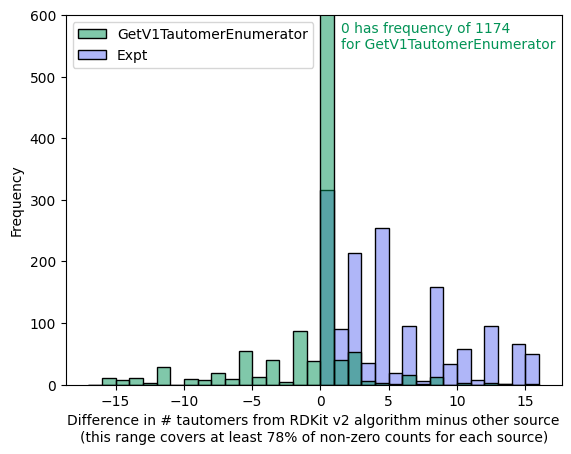

In [ ]:
# Plot histogram of n_tauts_diff for sources which have data for all refs

# [source for source in sources.keys() if sources[source] == "all"]

# n_tauts_diff_all = {source: n_tauts_diff[source] for source in sources.keys() if sources[source] == "all"}
n_tauts_diff_all = {source: n_tauts_diff[f"{source}"] for source in sources.keys() if sources[source] == "all"}

# Set the x bounds (will go from negative to positive of this value)
x_len = 17

# Set the histogram bins so there will be a bin (bar) for each integer value
bins = range(-1 * x_len, x_len, 1)

# Calculate the percent of each data series (excluding delta=0) this plot covers

# Create dictionaries to store values in; keys will be data sources
n_tauts_diff_no_zeros_this_range = dict()
non_zero_counts_this_range = dict()
# for source in sources_compare.keys():
for source in n_tauts_diff_all.keys():
    print(f"{source=}")
    n_tauts_diff_no_zeros_this_range.update(
        {source: [diff for diff in n_tauts_diff_no_zeros[source] if abs(diff) <= x_len]}
        # {source: [diff for diff in n_tauts_diff_no_zeros[f"tauts{source}"] if abs(diff) <= x_len]}
    )
    non_zero_counts_this_range.update(
        {
            source: len(n_tauts_diff_no_zeros_this_range[source])
            / len(n_tauts_diff_no_zeros[source])
            # / len(n_tauts_diff_no_zeros[f"tauts{source}"])
        }
    )
non_zero_counts_this_range_min = min(list(non_zero_counts_this_range.values()))

# Set an accessible color palette from https://venngage.com/tools/accessible-color-palette-generator
colors = [
    "#029356",
    # "#009eb0",
    # "#0073e6",
    "#606ff3",
    # "#9b8bf4",
    ]
sns.set_palette(sns.color_palette(colors))

# Create the histogram plot
sns.histplot(n_tauts_diff_all, bins=bins)

plt.ylabel("Frequency")
xlabel = "Difference in # tautomers from RDKit v2 algorithm minus other source"
xlabel += f"\n(this range covers at least {non_zero_counts_this_range_min:.0%} of non-zero counts for each source)"
plt.xlabel(xlabel)

# Limit the max y to avoid making smaller y values too hard to discern
plt.ylim(0, 600)

# Because this max y cuts off the y value for GetV1TautomerEnumerator at delta = 0, show the value as a label

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff["GetV1TautomerEnumerator"].count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0 for GetV1TautomerEnumerator
plt.text(
    1.5,
    max(plt.ylim()) * 0.9,
    f"0 has frequency of {frequency_at_zero}\nfor GetV1TautomerEnumerator",
    ha="left",
    va="bottom",
    color=colors[0],
)

plt.show()

source='GetV1TautomerEnumerator'


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

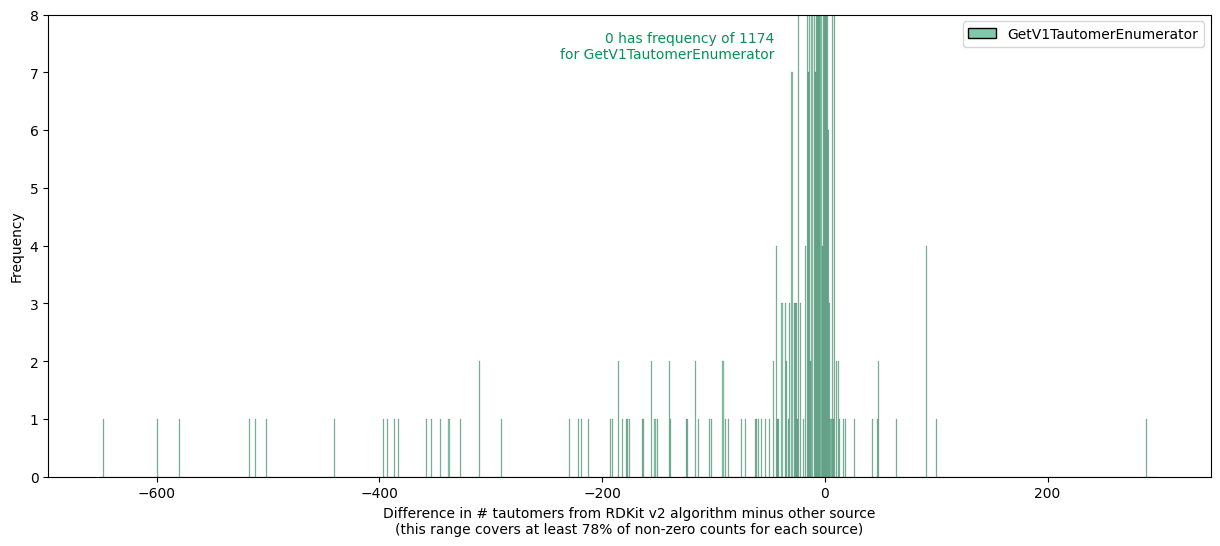

In [ ]:
# Plot histogram of n_tauts_diff for sources which have data for all refs

# [source for source in sources.keys() if sources[source] == "all"]

# n_tauts_diff_all = {source: n_tauts_diff[source] for source in sources.keys() if sources[source] == "all"}
n_tauts_diff_all = {source: n_tauts_diff[f"{source}"] for source in sources.keys() if source == "GetV1TautomerEnumerator"}

# Set the x bounds (will go from negative to positive of this value)
x_axis_min = -650
x_axis_max = 300

# Set the histogram bins so there will be a bin (bar) for each integer value
bins = range(x_axis_min, x_axis_max, 1)

# Calculate the percent of each data series (excluding delta=0) this plot covers

# Create dictionaries to store values in; keys will be data sources
n_tauts_diff_no_zeros_this_range = dict()
non_zero_counts_this_range = dict()
for source in n_tauts_diff_all.keys():
    print(f"{source=}")
    n_tauts_diff_no_zeros_this_range.update(
        {source: [diff for diff in n_tauts_diff_no_zeros[source] if abs(diff) <= x_len]}
    )
    non_zero_counts_this_range.update(
        {
            source: len(n_tauts_diff_no_zeros_this_range[source])
            / len(n_tauts_diff_no_zeros[source])
        }
    )
non_zero_counts_this_range_min = min(list(non_zero_counts_this_range.values()))

# Set an accessible color palette from https://venngage.com/tools/accessible-color-palette-generator
colors = [
    "#029356",
    # "#009eb0",
    # "#0073e6",
    "#606ff3",
    # "#9b8bf4",
    ]
sns.set_palette(sns.color_palette(colors))

# Set the width and height of the plot
plt.figure(figsize=(15, 6))  # Adjust the width as per your requirement

# Create the histogram plot
sns.histplot(n_tauts_diff_all, bins=bins)

plt.ylabel("Frequency")
xlabel = "Difference in # tautomers from RDKit v2 algorithm minus other source"
xlabel += f"\n(this range covers at least {non_zero_counts_this_range_min:.0%} of non-zero counts for each source)"
plt.xlabel(xlabel)

# Limit the max y to avoid making smaller y values too hard to discern
plt.ylim(0, 8)

# Because this max y cuts off the y value for GetV1TautomerEnumerator at delta = 0, show the value as a label

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff["GetV1TautomerEnumerator"].count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0 for GetV1TautomerEnumerator
plt.text(
    -45,
    max(plt.ylim()) * 0.9,
    f"0 has frequency of {frequency_at_zero}\nfor GetV1TautomerEnumerator",
    ha="right",
    va="bottom",
    color=colors[0],
)

plt.show()

In [ ]:
n_tauts_diff_no_zeros_this_range.keys()

dict_keys(['GetV1TautomerEnumerator'])

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

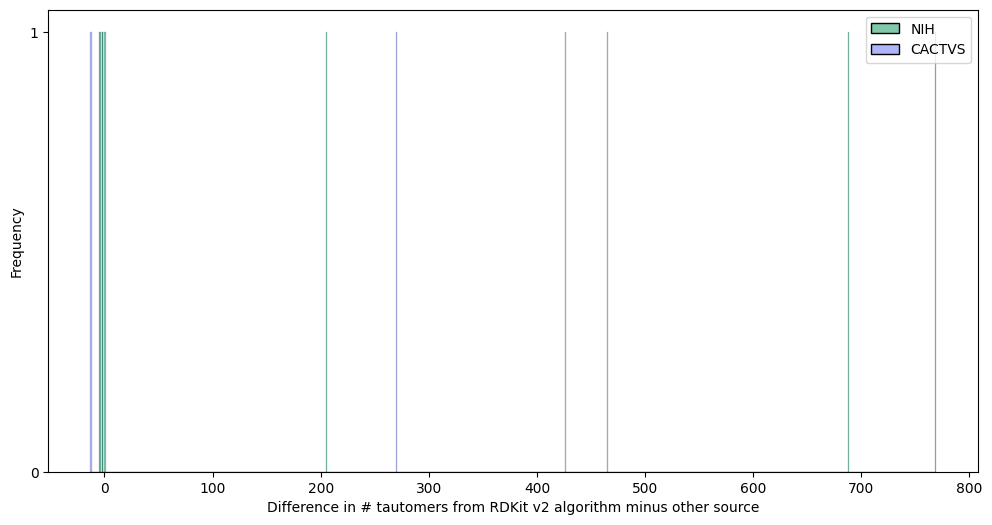

In [ ]:
# Plot histogram of n_tauts_diff for sources which do not have data for all refs, because each molecule is run manually
n_tauts_diff_manual = {source: n_tauts_diff[source] for source in sources.keys() if sources[source] == "manual"}

#TODO instead of using .to_list and then min() and max(), use Polars expressions to get min and max

# Set the histogram bins so there will be a bin (bar) for each integer value
combined_set = set(item for sublist in n_tauts_diff_manual.values() for item in sublist)
x_min, x_max = min(combined_set), max(combined_set)

bins = range(x_min, x_max+1, 1)

colors = [
    # "#029356",
    "#009eb0",
    # "#0073e6",
    # "#606ff3",
    "#9b8bf4",
    ]

plt.figure(figsize=(12, 6))  # Adjust the width and height as needed
sns.histplot(
    n_tauts_diff_manual, 
    bins=bins,
    )
sns.set_palette(sns.color_palette(colors))

# Set the x bounds (will go from negative to positive of this value)

plt.ylabel("Frequency")
xlabel = f"Difference in # tautomers from RDKit v2 algorithm minus other source"
plt.xlabel(xlabel)

# Get the current axis from the plot
ax = plt.gca()

# Set y-axis ticks to be at only integer values
ax.yaxis.set_major_locator(MultipleLocator(1))

plt.show()

n_tauts_diff_InChI_large=[138, 132, 241, 273, 314, 197, 207, 215, 206, 238, 107, 147, 290, 121, 257, 105, 147, 467, 200, 197, 183, 129, 397, 270, 107, 197, 264, 147, 147, 124, 209, 126, 200, 258, 201, 341, 147, 269, 112, 197, 147]
x range: 0 to 467


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


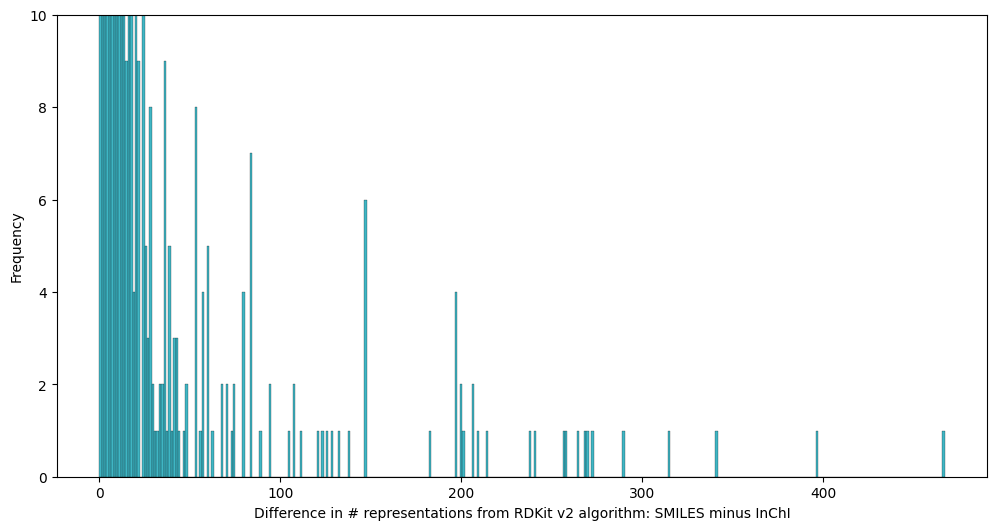

In [ ]:
# Plot histogram of n_tauts_diff for InChI compared to SMILES for RDKit V2
n_tauts_diff_InChI = df_melted_aggregated["nDiff_TautomerEnumerator_InChI"].to_list()

n_tauts_diff_InChI_large = [item for item in n_tauts_diff_InChI if item > 100]
print(f"{n_tauts_diff_InChI_large=}")

#TODO instead of using .to_list and then min() and max(), use Polars expressions to get min and max
x_min, x_max = min(n_tauts_diff_InChI), max(n_tauts_diff_InChI)
print(f"x range: {x_min} to {x_max}")
# bins = range(x_min, x_max+1, 1)

plt.figure(figsize=(12, 6))  # Adjust the width and height as needed
sns.histplot(
    df_melted_aggregated["nDiff_TautomerEnumerator_InChI"], 
    # bins=bins,
    )
# sns.set_palette(sns.color_palette(colors))

# Set the x bounds (will go from negative to positive of this value)

plt.ylabel("Frequency")
xlabel = f"Difference in # representations from RDKit v2 algorithm: SMILES minus InChI"
plt.xlabel(xlabel)

# Limit the max y to avoid making smaller y values too hard to discern
plt.ylim(0, 10)

#TODO Add label for frequency at 0

plt.show()

In [ ]:
def align_ordered_iterables(
        ordered_iterable1: list|tuple,
        ordered_iterable2: list|tuple,
        filler = "",
) -> Iterable:
    """Align the second ordered iterable under the first (in columns), using the filler for items in list1 not in list2, 
    for example:
    
    input:
    list1: a,  c,  b
    list2: a,  f,  c,  e,  d

    output:
    list2: a,  c, "",  f,  e,  d

    Note that no other ordering is applied to either input iterable, 
    and items in the second which are not in the first will be kept in their input order.
    If you want them to be ordered in some way, for example alphabetically, order them before calling this function.

    :param list1: Template list
    :param list2: List to be aligned under the template list
    :param filler: The filler entry to use to provide an "empty" column to align list2 under list1; default is empty string but can be a number or anything else
    :returns: Aligned list2 such that its entries will line up under the same values in list1, or be placed to the right if they are not in list1
    """
    # If either list has no elements, return the initial ordered_iterable2
    if any([len(ordered_iterable1)==0, len(ordered_iterable2)==0]):
        return ordered_iterable2   
    
    # Determine index for each element in ordered_iterable2:
    ordered_iterable2_indices = []
    ordered_iterable2_index_max = len(ordered_iterable1) - 1
    for ordered_iterable2_item in ordered_iterable2:
        try:
            ordered_iterable2_index = ordered_iterable1.index(ordered_iterable2_item)
        # If item from input 2 isn't in input 1, append item to the (growing) index list
        except ValueError:
            ordered_iterable2_index_max += 1
            ordered_iterable2_index = ordered_iterable2_index_max
        # If get an AttributeError, tell user that have a bad data type
        except AttributeError:
            raise AttributeError(f"The first iterable input must be a list or tuple, not a set or dictionary; it is {ordered_iterable1}, which is a {type(ordered_iterable1).__name__}")
        ordered_iterable2_indices.append(ordered_iterable2_index)

    # Create "empty" (all filler) ordered_iterable2 aligned--may be longer than ordered_iterable2 due to blank spaces
    ordered_iterable2_aligned = [filler] * (max(ordered_iterable2_indices) + 1)

    # Slot in items from ordered_iterable2 to overwrite filler entries
    for i, ordered_iterable2_col in enumerate(ordered_iterable2_indices):
        try:
            ordered_iterable2_aligned[ordered_iterable2_col] = ordered_iterable2[i]
        except (TypeError, KeyError):
                raise TypeError(f"The second iterable input must be a list or tuple, not a set or dictionary; it is {ordered_iterable2}, which is a {type(ordered_iterable2).__name__}")

    return ordered_iterable2_aligned

In [ ]:
df_melted_aggregated_different.filter(pl.col("Ref").is_in([1704, 1512, 890]))

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI,n_TautomerEnumerator_InChI,tauts_Expt,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_NIH,n_CACTVS,n_Expt,same_GetV1TautomerEnumerator,nDiff_GetV1TautomerEnumerator,same_NIH,nDiff_NIH,same_CACTVS,nDiff_CACTVS,same_TautomerEnumerator_InChI,nDiff_TautomerEnumerator_InChI,same_Expt,nDiff_Expt
i64,list[str],list[str],list[str],list[str],list[str],list[str],u32,list[str],u32,u32,u32,u32,u32,bool,i64,bool,i64,bool,i64,bool,i64,bool,i64
1704,"[""C=c1c(C=O)cc(C)cc1=CO"", ""Cc1cc(C=O)c(C)c(C=O)c1""]","[""C=c1c(C=O)cc(C)cc1=CO"", ""C=C1C(C=O)=CC(C)=CC1C=O"", ""Cc1cc(C=O)c(C)c(C=O)c1""]","[""C=c1c(C=O)cc(C)cc1=CO"", ""Cc1cc(C=O)c(C)c(C=O)c1""]","[""C=C1C(C=O)=CC(C)C=C1C=O"", ""Cc1cc(C=O)c(C)c(C=O)c1"", … ""C=c1c(C=O)cc(C)cc1=CO""]","[""CC1=CC(=C(C(=C1)C=O)C)C=O"", ""CC1=CC(C(C(=C1)C=O)=C)C=O"", … ""C=C\1C(=CC(=CC1=C\O)C)C=O""]","[""InChI=1S/C10H10O2/c1-7-3-9(5-11)8(2)10(4-7)6-12/h3-6H,1-2H3"", ""InChI=1S/C10H10O2/c1-7-3-9(5-11)8(2)10(4-7)6-12/h3-6,9H,2H2,1H3"", ""InChI=1S/C10H10O2/c1-7-3-9(5-11)8(2)10(4-7)6-12/h3-6,11H,2H2,1H3""]",3,"[""C=c1c(C=O)cc(C)cc1=CO"", ""Cc1cc(C=O)c(C)c(C=O)c1""]",3,2,5,5,2,false,1,false,-2,false,-2,false,0,false,1
1512,"[""CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1"", ""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1""]","[""CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1"", ""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", ""CCP(CC)(=NC1=CC(C(c2ccccc2)(c2ccccc2)c2ccccc2)=CC(C(C)(C)C)C1=O)c1ccccc1""]","[""CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1"", ""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1""]","[""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", ""CCP1(CC)(c2ccccc2)N=C2C=C(C(c3ccccc3)(c3ccccc3)c3ccccc3)C=C(C(C)(C)C)C2O1"", … ""CC=P(CC)(NC1C=C(C(c2ccccc2)(c2ccccc2)c2ccccc2)C=C(C(C)(C)C)C1=O)c1ccccc1""]","[""CC[P]6(CC)(C1=CC=CC=C1)NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O6"", ""CC[P]6(CC)(C1=CC=CC=C1)NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O6"", … ""CC[P](CC)(=NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O)C5=CC=CC=C5""]","[""InChI=1S/C39H42NOP/c1-6-42(7-2,34-26-18-11-19-27-34)40-36-29-33(28-35(37(36)41)38(3,4)5)39(30-20-12-8-13-21-30,31-22-14-9-15-23-31)32-24-16-10-17-25-32/h8-29,35H,6-7H2,1-5H3"", ""InChI=1S/C39H42NOP/c1-6-42(7-2,34-26-18-11-19-27-34)40-36-29-33(28-35(37(36)41)38(3,4)5)39(30-20-12-8-13-21-30,31-22-14-9-15-23-31)32-24-16-10-17-25-32/h8-29,41H,6-7H2,1-5H3"", ""InChI=1S/C39H42NOP/c1-6-42(7-2,34-26-18-11-19-27-34)40-36-29-33(28-35(37(36)41-42)38(3,4)5)39(30-20-12-8-13-21-30,31-22-14-9-15-23-31)32-24-16-10-17-25-32/h8-29,40H,6-7H2,1-5H3""]",3,"[""CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1"", ""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1""]",3,2,8,16,2,false,1,false,-5,false,-13,false,0,false,1
890,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43""]","[""COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c4c(c(=O)cc(OC)c4c4c(OC)cc(=O)c(c1O)c24)=C(O)C(OC)C3=C[C@H](C)OC(=O)c1ccc(O)cc1"", ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)C3C=CC(=O)C=C3)c3c2c1c1c2c3C(C[C@@H](C)OC(=O)c3ccccc3)=C(OC)C(=O)C=2C(=O)CC=1OC"", … ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c2c(c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c32)C(=O)CC=1OC""]","[""COC1=CC(=O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c(c(O)c(OC)c(=C[C@H](C)OC(=O)C4C=CC(=O)C=C4)c23)C(O)=CC1OC"", ""COC1=C(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(c(O)cc(OC)c3c3c4c(c(O)c(OC)c(=C[C@H](C)OC(=O)c5ccc(O)cc5)c24)C(=O)CC=3OC)C1=O"", … ""COC1=CC(=O)C2=c3c1c1c(OC)cc(O)c4

In [ ]:
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 73)
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1704) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1688) # Bad--weird structure drawing
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1689) # Bad--weird structure drawing
df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 890) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1758) # Bad--weird structure drawing
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1512) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 457)
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 467)
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 891)
df_melted_aggregated_different_example

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI,n_TautomerEnumerator_InChI,tauts_Expt,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_NIH,n_CACTVS,n_Expt,same_GetV1TautomerEnumerator,nDiff_GetV1TautomerEnumerator,same_NIH,nDiff_NIH,same_CACTVS,nDiff_CACTVS,same_TautomerEnumerator_InChI,nDiff_TautomerEnumerator_InChI,same_Expt,nDiff_Expt
i64,list[str],list[str],list[str],list[str],list[str],list[str],u32,list[str],u32,u32,u32,u32,u32,bool,i64,bool,i64,bool,i64,bool,i64,bool,i64
890,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43""]","[""COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c4c(c(=O)cc(OC)c4c4c(OC)cc(=O)c(c1O)c24)=C(O)C(OC)C3=C[C@H](C)OC(=O)c1ccc(O)cc1"", ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)C3C=CC(=O)C=C3)c3c2c1c1c2c3C(C[C@@H](C)OC(=O)c3ccccc3)=C(OC)C(=O)C=2C(=O)CC=1OC"", … ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c2c(c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c32)C(=O)CC=1OC""]","[""COC1=CC(=O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c(c(O)c(OC)c(=C[C@H](C)OC(=O)C4C=CC(=O)C=C4)c23)C(O)=CC1OC"", ""COC1=C(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(c(O)cc(OC)c3c3c4c(c(O)c(OC)c(=C[C@H](C)OC(=O)c5ccc(O)cc5)c24)C(=O)CC=3OC)C1=O"", … ""COC1=CC(=O)C2=c3c1c1c(OC)cc(O)c4c(O)c(OC)c(=C[C@H](C)OC(=O)C5=CCC(=O)C=C5)c(c3=C(C[C@@H](C)OC(=O)c3ccccc3)C(OC)C2=O)c41""]","[""COC1=c2c3c(c(=O)c(OC)c(C[C@H](C)OC(=O)c4ccc(O)cc4)c3c3c(C[C@@H](C)OC(=O)c4ccccc4)c(OC)c(O)c4c(=O)cc(OC)c2c43)C(=O)C1"", ""COC1=c2c3c(c(=O)c(OC)c(C[C@@H](C)OC(=O)c4ccccc4)c3c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(O)c4c(=O)cc(OC)c2c43)C(=O)C1"", … ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c1c3C(C[C@H](C)OC(=O)C1=CCC(=O)C=C1)=C(OC)C2=O""]","[""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=O)C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67"", ""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67)O"", … ""COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7""]","[""InChI=1S/C44H38O13/c1-20(56-43(50)22-10-8-7-9-11-22)16-25-31-32-26(17-21(2)57-44(51)23-12-14-24(45)15-13-23)42(55-6)40(49)34-28(47)19-30(53-4)36(38(32)34)35-29(52-3)18-27(46)33(37(31)35)39(48)41(25)54-5/h7-16,18,20-21,41,46,51H,17,19H2,1-6H3/t20-,21+,41?/m1/s1"", ""InChI=1S/C44H38O13/c1-20(56-43(50)22-10-8-7-9-11-22)16-25-31-32-26(17-21(2)57-44(51)23-12-14-24(45)15-13-23)42(55-6)40(49)34-28(47)19-30(53-4)36(38(32)34)35-29(52-3)18-27(46)33(37(31)35)39(48)41(25)54-5/h7-14,18-21,42,46H,15-17H2,1-6H3/t20-,21+,42?/m1/s1"", … ""InChI=1S/C44H38O13/c1-20(56-43(50)22-10-8-7-9-11-22)16-25-31-32-26(17-21(2)57-44(51)23-12-14-24(45)15-13-23)42(55-6)40(49)34-28(47)19-30(53-4)36(38(32)34)35-29(52-3)18-27(46)33(37(31)35)39(48)41(25)54-5/h7-15,17,19-21,23,47,49H,16,18H2,1-6H3/t20-,21+/m1/s1""]",454,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43""]",723,435,35,258,2,false,288,false,688,false,465,false,269,false,721


In [ ]:
# Draw.MolsToGridImage(df_melted_aggregated_different_example)

In [ ]:
# Output SMILES for all RDKit V2 tautomers for a ref
# tauts_890_rdkitv2 = df_melted_aggregated_different_example[0]["flat_tautsTautomerEnumerator"].item().to_list()
# import csv

# filename = "../data/ref890_rdkit_v2_tautomers.csv"

# # Open the file in write mode
# with open(filename, 'w', newline='') as csvfile:
#     # Create a CSV writer object
#     csvwriter = csv.writer(csvfile)

#     # Write each item of the list on its own line
#     csvwriter.writerows([[item] for item in tauts_890_rdkitv2])


In [ ]:
df_melted_aggregated_300 = df_melted_aggregated_different.filter(pl.col("n_TautomerEnumerator") > 300)
smls_v2_300 = [item[0] for item in df_melted_aggregated_300["tauts_TautomerEnumerator"].to_list()]
# df_melted_aggregated_different_example["flat_tautsTautomerEnumerator"].to_list()

In [ ]:
df_melted_aggregated_300[3]

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI,n_TautomerEnumerator_InChI,tauts_Expt,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_NIH,n_CACTVS,n_Expt,same_GetV1TautomerEnumerator,nDiff_GetV1TautomerEnumerator,same_NIH,nDiff_NIH,same_CACTVS,nDiff_CACTVS,same_TautomerEnumerator_InChI,nDiff_TautomerEnumerator_InChI,same_Expt,nDiff_Expt
i64,list[str],list[str],list[str],list[str],list[str],list[str],u32,list[str],u32,u32,u32,u32,u32,bool,i64,bool,i64,bool,i64,bool,i64,bool,i64
846,"[""CCc1cc(O)c2c(c1O)C(=O)C=C(O)C2=O"", ""CCC1=CC(=O)c2c(O)c(O)cc(O)c2C1=O""]","[""C=CC1CC(=O)C2C(=O)C(=O)CC(O)=C2C1=O"", ""C=CC1CC(=O)C2C(=O)C(O)=CC(O)=C2C1=O"", … ""C=CC1CC(=O)c2c(O)c(O)cc(O)c2C1=O""]","[""C=CC1CC(=O)C2C(=O)C(=O)CC(O)=C2C1=O"", ""C=CC1CC(=O)C2C(=O)C(O)=CC(O)=C2C1=O"", … ""C=CC1=CC(=O)C2=C(O)C(=O)CC(=O)C2C1O""]",[],[],"[""InChI=1S/C12H10O5/c1-2-5-3-6(13)10-9(11(5)16)7(14)4-8(15)12(10)17/h2-3,12-13,17H,4H2,1H3"", ""InChI=1S/C12H10O5/c1-2-5-3-6(13)10-9(11(5)16)7(14)4-8(15)12(10)17/h2-4,13-17H,1H2"", … ""InChI=1S/C12H10O5/c1-2-5-3-6(13)10-9(11(5)16)7(14)4-8(15)12(10)17/h2-4,9,12-13,15,17H,1H2""]",213,"[""CCc1cc(O)c2c(c1O)C(=O)C=C(O)C2=O"", ""CCC1=CC(=O)c2c(O)c(O)cc(O)c2C1=O""]",410,574,0,0,2,false,-164,false,null,false,null,false,197,false,408


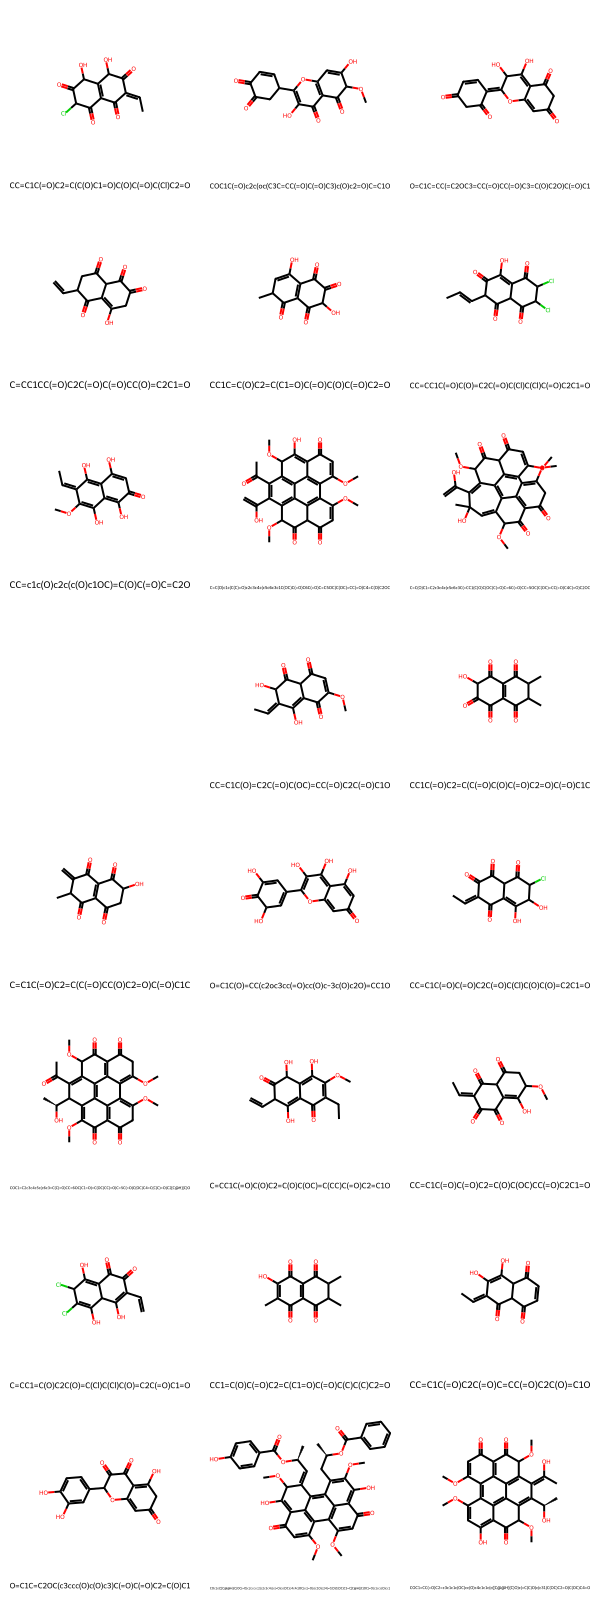

In [ ]:
mols_v2_300 = [Chem.MolFromSmiles(sml) for sml in smls_v2_300]
Draw.MolsToGridImage(mols_v2_300, legends = smls_v2_300)

In [ ]:
# For the various data sources, extract SMILES, align them sequentially, and create RDKit molecules for drawing 
smls_expt = df_melted_aggregated_different_example.select("tauts_Expt").item().to_list()
smls_v2 = df_melted_aggregated_different_example.select("tauts_TautomerEnumerator").item().to_list()
smls_v2_aligned = align_ordered_iterables(smls_expt, smls_v2)
smls_v1 = df_melted_aggregated_different_example.select("tauts_GetV1TautomerEnumerator").item().to_list()
smls_v1_aligned = align_ordered_iterables(smls_v2_aligned, smls_v1)
smls_nih = df_melted_aggregated_different_example.select("tauts_NIH").item().to_list()
smls_nih_aligned = align_ordered_iterables(smls_v1_aligned, smls_nih)
smls_cactvs = df_melted_aggregated_different_example.select("tauts_CACTVS").item().to_list()
smls_cactvs_aligned = align_ordered_iterables(smls_nih_aligned, smls_cactvs)

tauts_expt = [mol_from_sml(sml) for sml in smls_expt]
tauts_v2_aligned = [mol_from_sml(sml) if sml else None for sml in smls_v2_aligned]
tauts_v1_aligned = [mol_from_sml(sml) if sml else None for sml in smls_v1_aligned]
tauts_nih_aligned = [mol_from_sml(sml) if sml else None for sml in smls_nih_aligned]
tauts_cactvs_aligned = [mol_from_sml(sml) if sml else None for sml in smls_cactvs_aligned]

In [ ]:
def find_first_non_none_index(lst):
    for i, item in enumerate(lst):
        if item is not None:
            return i
    return None  # Return None if all elements are None

Label RDKit v2 code: 723 tautomers: col_to_label=0
  Label will go on col 0 for row 0
Label RDKit v1 code: 435 tautomers: col_to_label=0
  Label will go on col 0 for row 1
Label NIH code: 35 tautomers: col_to_label=0
  Label will go on col 0 for row 2
Label CACTVS code: 258 tautomers: col_to_label=None
  No label for row 3


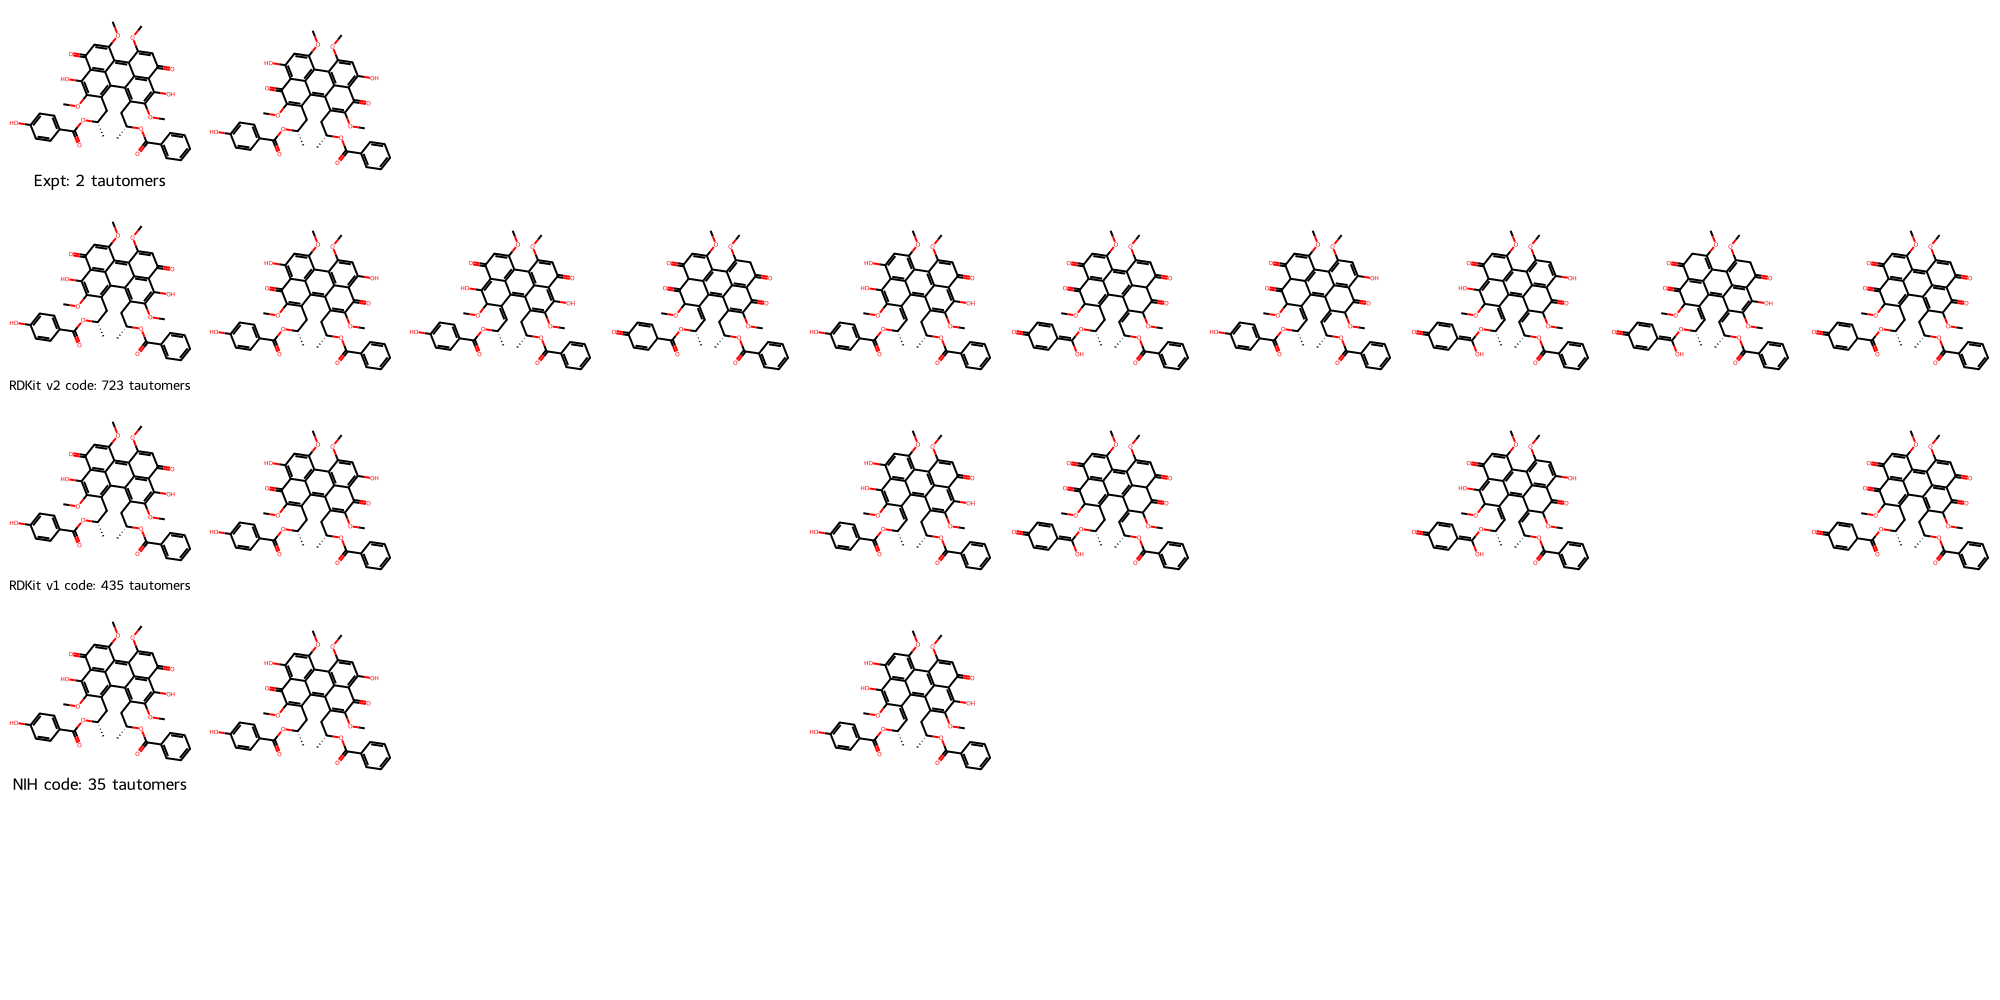

In [ ]:
# Plot all sets of tautomers

# Limit number of columns so structures will be readable
max_cols = 10
# Create nested (2D) data structures for Draw.MolsMatrixToGridImage
smls_matrix = [
    smls_expt,
    smls_v2_aligned,
    smls_v1_aligned,
]
tauts_matrix = [
    tauts_expt[:max_cols],
    tauts_v2_aligned[:max_cols],
    tauts_v1_aligned[:max_cols],
]

row_labels = [
    f"Expt: {len(smls_expt)} tautomers",
    f"RDKit v2 code: {len(smls_v2)} tautomers",
    f"RDKit v1 code: {len(smls_v1)} tautomers",
]

# If NIH tautomers generated, add row for them
if not all([sml is None for sml in smls_nih]):
    smls_matrix.append(smls_nih_aligned)
    tauts_matrix.append(tauts_nih_aligned[:max_cols])
    row_labels.append(f"NIH code: {len(smls_nih)} tautomers")

# If CACTVS tautomers generated, add row for them
if not all([sml is None for sml in smls_cactvs]):
    smls_matrix.append(smls_cactvs)
    tauts_matrix.append(tauts_cactvs_aligned[:max_cols])
    row_labels.append(f"CACTVS code: {len(smls_cactvs)} tautomers")

# Initialize a legends matrix with empty strings
legends_matrix = [["" for item in row] for row in tauts_matrix]

# Label first non-empty column in each row with source and number of tautomers
# First row is the template that other rows align under, so first molecule will be non-empty
legends_matrix[0][0] = row_labels[0]
# For subsequent rows, any molecule could be empty (if it's not in the row(s) above)
for label_index, row_label in enumerate(row_labels[1:]):
    col_to_label = find_first_non_none_index(tauts_matrix[label_index+1])
    print(f"Label {row_label}: {col_to_label=}")

    if col_to_label != None:
        print(f"  Label will go on col {col_to_label} for row {label_index}")
        legends_matrix[label_index+1][col_to_label] = row_label
    else:
        print(f"  No label for row {label_index}")

# Align 2D structures based on maximum common substructure (mcs)
# Exclude blank entries to avoid problem with aligning empty molecules
tauts_all = [
    item for sublist in tauts_matrix for item in sublist if item is not None
]
mcs = rdFMCS.FindMCS(
    tauts_all,
    bondCompare=rdFMCS.BondCompare.CompareAny,
)
mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
Chem.Compute2DCoords(mcs_mol)
for m in tauts_all:
    Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

Draw.MolsMatrixToGridImage(
    molsMatrix=tauts_matrix, legendsMatrix=legends_matrix, useSVG=True, maxMols=1700
)

In [ ]:
tauts_v2 = [Chem.MolFromSmiles(sml) for sml in smls_v2_aligned]

mcs = rdFMCS.FindMCS(
    tauts_v2,
    bondCompare=rdFMCS.BondCompare.CompareAny,
)
mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
# If there is a maximum common substructure
if mcs_mol:
    # And it has atoms
    if mcs_mol.GetNumAtoms() > 0:
        Chem.Compute2DCoords(mcs_mol)
        for m in tauts_v2:
            Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)
            
        Draw.MolsToGridImage(tauts_v2, maxMols=100, molsPerRow=7)

Checking if is in kwargs: legends
Checking if is in kwargs: highlightAtoms
Checking if is in kwargs: highlightBonds


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  warnings.warn(


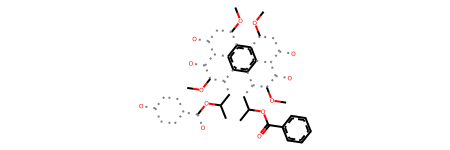

In [ ]:
# Show how large, and thus effective, MCS is if use bondCompare=rdFMCS.BondCompare.CompareAny
mcs_mol

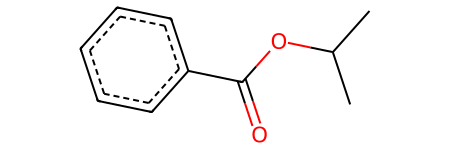

In [ ]:
# Show how much smaller, and thus ineffective, MCS is if don't use bondCompare=rdFMCS.BondCompare.CompareAny
mcs_strict = rdFMCS.FindMCS(
    tauts_v2,
)
mcs_smarts_strict = mcs_strict.smartsString
mcs_mol_strict = Chem.MolFromSmarts(mcs_smarts_strict)
mcs_mol_strict

## Acknowledgments

***Marc Niclaus***